<a href="https://colab.research.google.com/github/PascalLiPooKim/Football-prediction-model-project/blob/commenting-and-refactoring/footballPredictionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Imports

In [1]:
import pandas as pd # To read  csv files and process dataframes
import missingno as msn # To isualise the missing rows of data frames
import numpy as np
import plotly.express as px # To create interactive plots
import matplotlib.pyplot as plt
from joblib import dump, load # To downloand and load sklearn ML models
import itertools 
from typing import Tuple
from google.colab import files

In [5]:
!pip install feature_engine
from feature_engine import encoding

In [22]:
# Import the ML models used for classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA # For dimensionality reduction
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [23]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV # For cross-validation
from sklearn.pipeline import Pipeline # Use to assemble different techniques or/and ML models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, classification_report # Visualise prediction results
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import shuffle # To shuffle the data

# Exploratory Data Analysis (EDA)

## Team Info

In [ ]:
# Load the Team_info.csv file
team_info_df = pd.read_csv('https://raw.githubusercontent.com/PascalLiPooKim/Football-prediction-model-project/data-wrangling/Football_Data/Football_Data/Team_Info.csv')
team_info_df.head() # Take a peek at the dataframe

,Team,City,Country,Stadium,Capacity,Pitch
0,Wattenscheid 09,Bochum-Wattenscheid,Germany,Lohrheidestadion,16233,Natural
1,Hertha BSC,Berlín,Germany,Olympiastadion Berlin,76065,Natural
2,Unterhaching,Unterhaching,Germany,Sportpark Unterhaching,15053,Natural
3,Fortuna Köln,Cologne,Germany,Südstadion,14944,Natural
4,MSV Duisburg,Duisburgo,Germany,Schauinsland-Reisen-Arena,31514,Natural


In [ ]:
team_info_df.info() # Check the number of non-null rows and column type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Team      544 non-null    object
 1   City      544 non-null    object
 2   Country   544 non-null    object
 3   Stadium   447 non-null    object
 4   Capacity  544 non-null    object
 5   Pitch     447 non-null    object
dtypes: object(6)
memory usage: 25.6+ KB


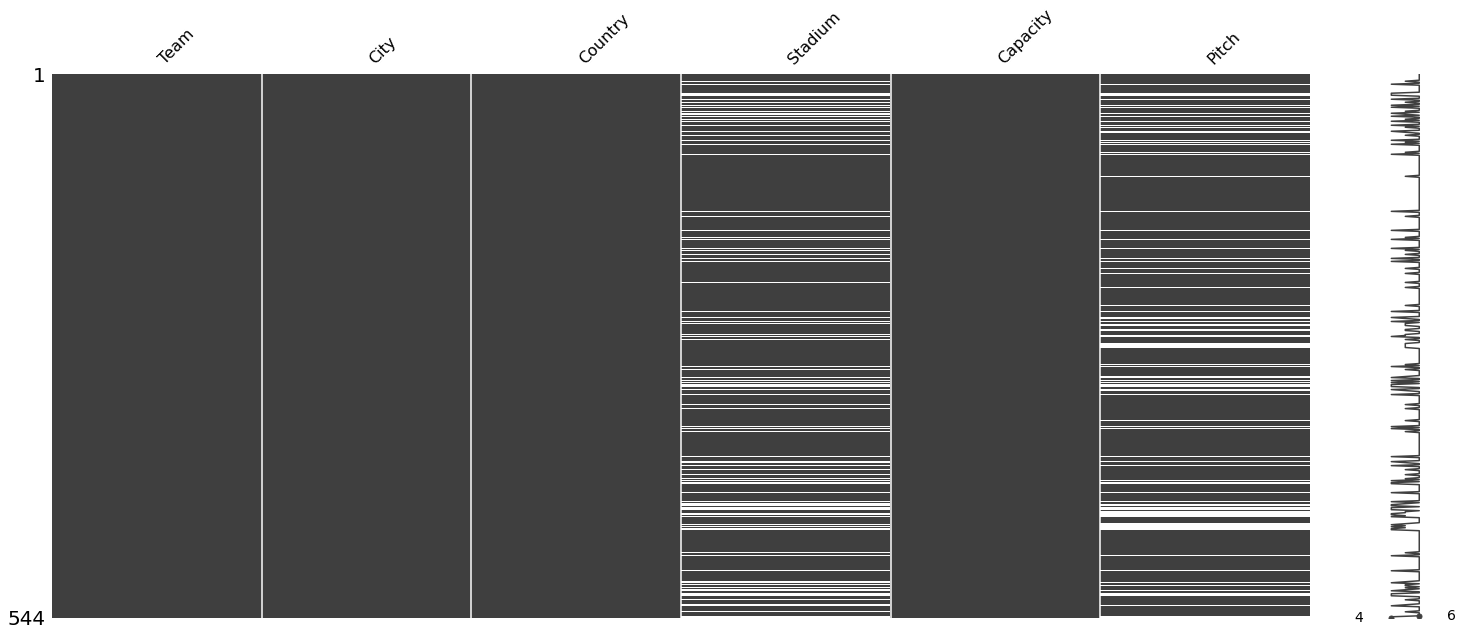

In [ ]:
msn.matrix(team_info_df) # Check the missing rows visually

In [ ]:
team_info_df.isnull().sum()/len(team_info_df) # Get number of nulls in terms of total rows

Team        0.000000
City        0.000000
Country     0.000000
Stadium     0.178309
Capacity    0.000000
Pitch       0.178309
dtype: float64

In [ ]:
team_info_cols_with_null = ['Stadium', 'Pitch'] # Columns that have missing values
for col in team_info_cols_with_null:
  # Take a peek at fraction of unique values in each column
  print(team_info_df[col].value_counts()/len(team_info_df)) 

Stadio Marc'Antonio Bentegodi      0.003676
Cerro del Espino                   0.003676
Stadio Città del Tricolore         0.003676
Cartagonova                        0.003676
Stadio Atleti Azzurri d'Italia     0.003676
                                     ...   
Stade Geoffroy-Guichard            0.001838
King Power Stadium                 0.001838
Stadion Niederrhein                0.001838
Ciudad Deportiva Del Villarreal    0.001838
Stadion Galgenwaard                0.001838
Name: Stadium, Length: 442, dtype: float64
Natural              0.648897
Grass                0.055147
Césped natural       0.038603
Césped Artificial    0.029412
grass                0.014706
Césped Natural       0.011029
natural              0.003676
Césped               0.003676
Artificial           0.003676
NATURAL              0.001838
AirFibr              0.001838
cesped real          0.001838
Cesped natural       0.001838
Natural grass        0.001838
natural grass        0.001838
cesped natural       0.

In [ ]:
team_info_df['Stadium'].unique() # Find out unique 'Stadium' values

array(['Lohrheidestadion', 'Olympiastadion Berlin',
       'Sportpark Unterhaching', 'Südstadion',
       'Schauinsland-Reisen-Arena', 'Stadion Ludwigspark',
       'Eintracht-Stadion', nan, 'osnatel-ARENA', 'MEP-Arena',
       'VELTINS-Arena', 'Stadion Essen', 'Schwarzwald-Stadion',
       'Neuer Tivoli', 'Merck-Stadion am Böllenfalltor', 'HDI-Arena',
       'GAZİ-Stadion auf der Waldau', 'Preußen-Stadion', 'Opel Arena',
       'Marschwegstadion', 'Wilhelm-Langrehr-Stadion', 'ERDGAS Sportpark',
       'Ernst-Abbe-Sportfeld', 'Steigerwaldstadion', 'Grünwalder Stadion',
       'Volkswagen-Arena', 'DKB Arena', 'Millerntor-Stadion',
       'ESPRIT arena', 'rewirpowerSTADION',
       'Frankfurter Volksbank Stadion', 'Grundig-Stadion', 'SchücoArena',
       'Commerzbank-Arena', 'Fritz-Walter-Stadion',
       'Sportpark Ronhof Thomas Sommer',
       'Stadion der Freundschaft, Cottbus', 'RheinEnergieStadion',
       'Stadion Niederrhein', 'Wildparkstadion', 'Bieberer Berg Stadion',
       'Bo

In [ ]:
# Replace missing values with the value 'Other' rather than using KNN imputer
team_info_df['Stadium'].fillna('Missing', inplace=True)

In [ ]:
# Check out the countries present in the data frame
team_info_df['Country'].unique()

array(['Germany', 'England', 'Netherlands', 'France', 'Portugal', 'Spain',
       'Italy'], dtype=object)

In [ ]:
# Getting an idea how many English teams are present in the data frame since
# we will start with them
england_teams = team_info_df[team_info_df['Country'] == 'England']
england_teams

,Team,City,Country,Stadium,Capacity,Pitch
87,West Ham,Londres,England,London Stadium,80000,Natural
88,Blackburn Rovers,Blackburn,England,Ewood Park,31367,Natural
89,Sheffield United,Sheffield,England,Bramall Lane,32702,Natural
90,Ipswich Town,Ipswich,England,Portman Road Stadium,30311,Natural
91,Sunderland,Sunderland,England,Stadium of Light,49000,Natural
...,...,...,...,...,...,...
278,Aston Villa,Birmingham,England,Villa Park,42788,Natural
279,Southampton,Southampton,England,St. Mary's Stadium,32689,Natural
280,Everton,Liverpool,England,Goodison Park,40569,Natural
281,Arsenal,Londres,England,Emirates Stadium,60355,Natural


In [ ]:
team_info_df['Pitch'].unique() # Get the unique values of the 'Pitch' column
# As it can be seen, there are values that should represent similar
# things as other values

array(['Natural', 'grass', 'Césped', nan, 'cesped natural', 'Grass',
       'cesped real', 'NATURAL', 'Césped Artificial', 'AirFibr ',
       'Natural grass', 'Césped Natural', 'Cesped natural',
       'Césped natural', 'natural grass', 'Artificial', 'natural'],
      dtype=object)

In [ ]:
# Quick look at the histogram of each of the unique 'Pitch' values
fig = px.histogram(team_info_df, x="Pitch")
fig.show()

In [ ]:
# Look at the rows whose 'Pitch' value is grass to identify if the 'Pitch'
# values should be turned to natural or artificial grass
team_info_df[team_info_df['Pitch'] == 'Grass']

,Team,City,Country,Stadium,Capacity,Pitch
27,Carl Zeiss Jena,Jena,Germany,Ernst-Abbe-Sportfeld,16000,Grass
28,Chemnitzer,Chemnitz,Germany,Missing,16061,Grass
37,FC Remscheid,Remscheid,Germany,Missing,"12,463",Grass
59,SV Babelsberg 03,Potsdam,Germany,Karl-Liebknecht-Stadion,"10,787",Grass
61,Eintracht Trier,Tréveris,Germany,Missing,"10,256",Grass
120,Grimsby Town,Grimsby,England,Blundell Park,9546,Grass
125,Luton Town,Luton,England,Kenilworth Road Stadium,"10,356",Grass
142,Wimbledon FC,London,England,Missing,"15,876",Grass
176,FC Omniworld,Almere,Netherlands,Missing,"4,501",Grass
180,Jong Twente,Enschede,Netherlands,Missing,"30,205",Grass


In [ ]:
# Look at the rows with only with the word 'Césped' in the 'Pitch' column
team_info_df[team_info_df['Pitch'] == 'Césped']

,Team,City,Country,Stadium,Capacity,Pitch
8,VfL Osnabrück,Osnabrück,Germany,osnatel-ARENA,16130,Césped
55,Kickers Offenbach,Offenbach,Germany,Bieberer Berg Stadion,25200,Césped


In [ ]:
# Check how what rows have missing 'Pitch' values
team_info_df[team_info_df['Pitch'].isna()] 

,Team,City,Country,Stadium,Capacity,Pitch
10,Blau-Weiß 1890 B.,Berlin,Germany,Missing,3000,NaN
19,Bayreuth SpVgg,Bayreuth,Germany,Missing,21500,NaN
20,Waldhof Mannheim,Mannheim,Germany,Missing,"25,667",NaN
21,FC 08 Homburg,Homburg,Germany,Missing,"16,488",NaN
25,Schweinfurt,Schweinfurt,Germany,Missing,15060,NaN
...,...,...,...,...,...,...
520,FC Savoia 1908,Savoia,Italy,Missing,12750,NaN
521,Fermana,Fermana,Italy,Missing,8850,NaN
531,Calcio,Foggia,Italy,Missing,16000,NaN
542,Pordenone,Pordenone,Italy,Missing,3089,NaN


In [ ]:
# Replace all the repeated values that aimed to represent the same thing with
# standard values

replace_from = ['Natural', 'grass', 'natural', 'natural grass', 'NATURAL', 
                'Natural grass', 'Grass', np.nan]
replace_to = ['Natural Grass']
to_replace = dict(itertools.product(replace_from, replace_to))

replace_from = ['Cesped natural', 'cesped natural', 'Césped natural', 
                'cesped real', 'Césped']
replace_to = ['Césped Natural']
to_replace.update(dict(itertools.product(replace_from, replace_to)))

replace_from = ['AirFibr ', 'Artificial']
replace_to = ['Césped Artificial']
to_replace.update(dict(itertools.product(replace_from, replace_to)))

team_info_df['Pitch'].replace(to_replace=to_replace, inplace=True)
team_info_df['Pitch'].unique()

array(['Natural Grass', 'Césped Natural', 'Césped Artificial'],
      dtype=object)

In [ ]:
fig = px.histogram(team_info_df, x="Pitch") # Check the new histogram
fig.show()

In [ ]:
def categories_encoder_decoder(df, cols) -> Tuple[dict, dict]:
  '''
  Function to convert non-numerical category values into numerical category 
  values (usually used for data imputation)
  '''
  category_dict_encode = {}
  category_dict_decode = {}
  for col in cols:
    # Convert the values to categories
      df[col] = df[col].astype('category') 

      categories = df[col].cat.categories
      
      # Map each non-numerial category value to an integer
      # Eg. {1: 'Category1', 2: 'Category2', ...}
      col_cat_dict = dict(enumerate(categories))
      
      # Create key-value paor for respective column
      category_dict_decode[col] = col_cat_dict
      
      # Create a dictionary from the inverted key-value pair of the previous
      # dictionary to replace back to the original non-numerical values
      # Eg. {'Category1': 1, 'Category2': 2, ...}
      col_cat_dict = {v:k for k,v in col_cat_dict.items()}
      
      category_dict_encode[col] = col_cat_dict

  return category_dict_encode, category_dict_decode

## Match Info

In [ ]:
# Load the Match_info.csv file into a dataframe
match_info_df = pd.read_csv('https://raw.githubusercontent.com/PascalLiPooKim/Football-prediction-model-project/data-wrangling/Football_Data/Football_Data/Match_Info.csv')
match_info_df.head()

,Link,Date_New,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red
0,/match/saarbrucken/stuttgarter-kickers/1990,"Saturday, 29 July 1989, 15:00",\nReferee: Hans-Jürgen Weber\n,0.0,0.0,3.0,0.0
1,/match/sc-freiburg/unterhaching/1990,"Saturday, 29 July 1989, 15:00",\nReferee: Kurt Wittke\n,1.0,0.0,0.0,0.0
2,/match/vfl-osnabruck/meppen/1990,"Saturday, 29 July 1989, 15:00",\nReferee: Werner Föckler\n,3.0,0.0,2.0,0.0
3,/match/rot-weiss-essen/schalke-04/1990,"Saturday, 29 July 1989, 15:00",\nReferee: Heinz Werner\n,2.0,0.0,2.0,0.0
4,/match/alemannia-aachen/msv-duisburg/1990,"Saturday, 29 July 1989, 15:00",\nReferee: Hans-Peter Dellwing\n,1.0,0.0,1.0,0.0


In [ ]:
match_info_df.info() # Check the number of rows with missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143348 entries, 0 to 143347
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Link         143348 non-null  object 
 1   Date_New     143348 non-null  object 
 2   Referee      143348 non-null  object 
 3   Home_Yellow  122798 non-null  float64
 4   Home_Red     122798 non-null  float64
 5   Away_Yellow  122798 non-null  float64
 6   Away_Red     122798 non-null  float64
dtypes: float64(4), object(3)
memory usage: 7.7+ MB


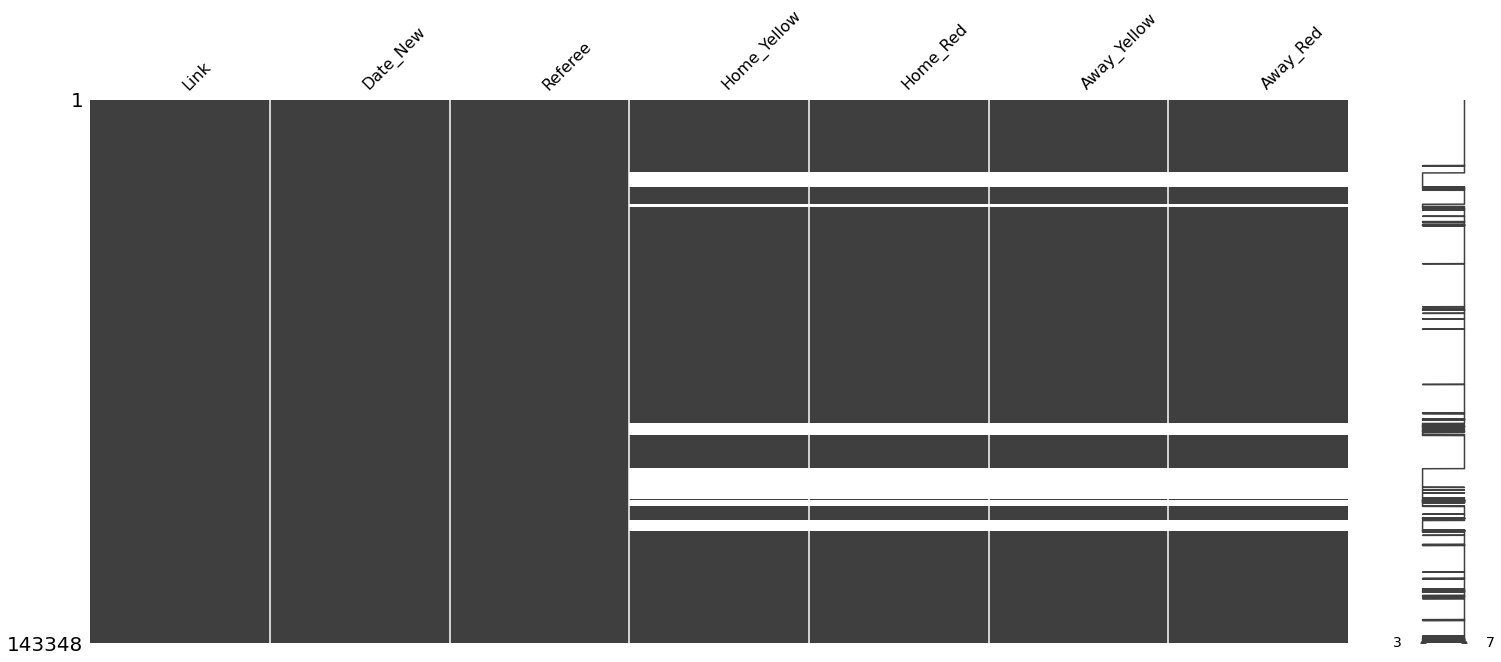

In [ ]:
msn.matrix(match_info_df) # Visualise the rows and columns with missing values

In [ ]:
# Look at the fraction of missing values
match_info_df.isnull().sum()/len(match_info_df)

Link           0.000000
Date_New       0.000000
Referee        0.000000
Home_Yellow    0.143357
Home_Red       0.143357
Away_Yellow    0.143357
Away_Red       0.143357
dtype: float64

In [ ]:
# Take columns with missing values
match_info_cols_with_null = ['Home_Yellow', 'Home_Red', 
                             'Away_Yellow', 'Away_Red'] 
match_info_cols_with_null

['Home_Yellow', 'Home_Red', 'Away_Yellow', 'Away_Red']

In [ ]:
# Assume that the missing values were meant to represent no cards
# were given in the matches and so 0
for col in match_info_cols_with_null:
  print('Before replacing: ', match_info_df[col].unique())
  # Replace here with zero
  match_info_df[col].replace(to_replace={np.nan: 0}, inplace=True)
  print('After replacing: ', match_info_df[col].unique())

Before replacing:  [ 0.  1.  3.  2.  4.  5.  6.  7.  8. nan  9. 10.]
After replacing:  [ 0.  1.  3.  2.  4.  5.  6.  7.  8.  9. 10.]
Before replacing:  [ 0.  1.  3.  2. nan]
After replacing:  [0. 1. 3. 2.]
Before replacing:  [ 3.  0.  2.  1.  4.  6.  5.  8.  7.  9. nan 10.]
After replacing:  [ 3.  0.  2.  1.  4.  6.  5.  8.  7.  9. 10.]
Before replacing:  [ 0.  1.  2.  3. nan  4.]
After replacing:  [0. 1. 2. 3. 4.]


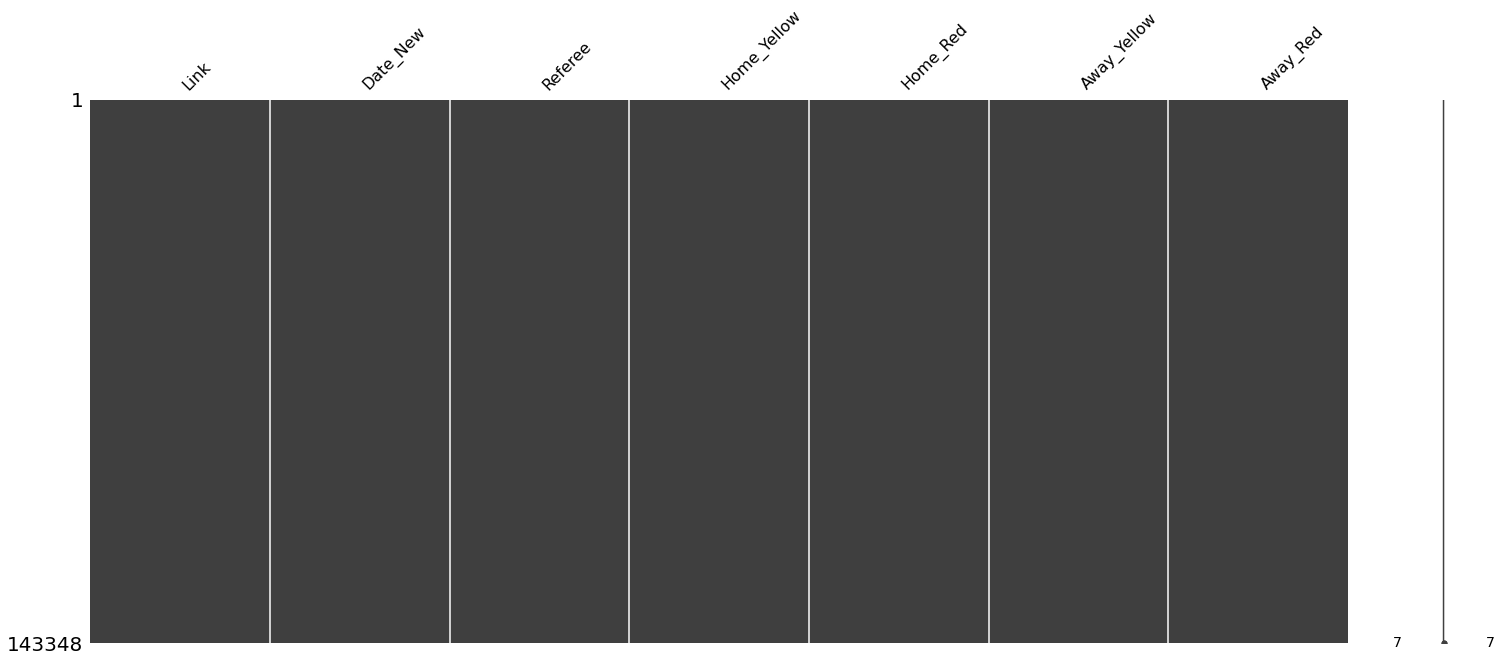

In [ ]:
msn.matrix(match_info_df) # Look again for any missing values

In [ ]:
# Convert the 'Date_New' column type ti datetime
match_info_df['Date_New'] = pd.to_datetime(match_info_df['Date_New'])
# Strip all unnecessary strings from the rows in the 'Referee' column
match_info_df['Referee'] = match_info_df['Referee'].str.strip().str.split(':')\
                          .str[-1].str.strip()

# Replace missing values with the value 'Other'                     
match_info_df['Referee'].replace(to_replace={'':'Missing'}, inplace=True)
match_info_df

,Link,Date_New,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red
0,/match/saarbrucken/stuttgarter-kickers/1990,1989-07-29 15:00:00,Hans-Jürgen Weber,0.0,0.0,3.0,0.0
1,/match/sc-freiburg/unterhaching/1990,1989-07-29 15:00:00,Kurt Wittke,1.0,0.0,0.0,0.0
2,/match/vfl-osnabruck/meppen/1990,1989-07-29 15:00:00,Werner Föckler,3.0,0.0,2.0,0.0
3,/match/rot-weiss-essen/schalke-04/1990,1989-07-29 15:00:00,Heinz Werner,2.0,0.0,2.0,0.0
4,/match/alemannia-aachen/msv-duisburg/1990,1989-07-29 15:00:00,Hans-Peter Dellwing,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
143343,/match/sunderland-afc/oxford-city/1999,1998-09-19 00:00:00,Anthony Leake,1.0,0.0,0.0,0.0
143344,/match/fc-gueugnon/bastia/1994,1994-05-17 00:00:00,Jacques Poulain,0.0,0.0,0.0,0.0
143345,/match/tranmere-rovers/wolverhampton/1999,1999-01-08 00:00:00,Kevin Lynch,2.0,0.0,1.0,0.0
143346,/match/sochaux/guingamp/2021,2021-02-27 19:00:00,Baert A.,0.0,0.0,2.0,0.0


In [ ]:
# Create new columns so that they can be added to other data frames based on
# these values
home_teams = []
away_teams = []
seasons = []
for i, row in match_info_df.iterrows():
  # Get the teams and season values from the 'Link' column
  e = row['Link'].split('/') 
  home_teams.append(e[2].replace('-', ' ').replace('afc', '').replace('fc', ''))
  away_teams.append(e[3].replace('-', ' ').replace('afc', '').replace('fc', ''))
  seasons.append(e[4])

# Assign each list to their respective new columns
match_info_df['Home_Team'] = home_teams
match_info_df['Away_Team'] = away_teams
match_info_df['Season'] = seasons
match_info_df

,Link,Date_New,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red,Home_Team,Away_Team,Season
0,/match/saarbrucken/stuttgarter-kickers/1990,1989-07-29 15:00:00,Hans-Jürgen Weber,0.0,0.0,3.0,0.0,saarbrucken,stuttgarter kickers,1990
1,/match/sc-freiburg/unterhaching/1990,1989-07-29 15:00:00,Kurt Wittke,1.0,0.0,0.0,0.0,sc freiburg,unterhaching,1990
2,/match/vfl-osnabruck/meppen/1990,1989-07-29 15:00:00,Werner Föckler,3.0,0.0,2.0,0.0,vfl osnabruck,meppen,1990
3,/match/rot-weiss-essen/schalke-04/1990,1989-07-29 15:00:00,Heinz Werner,2.0,0.0,2.0,0.0,rot weiss essen,schalke 04,1990
4,/match/alemannia-aachen/msv-duisburg/1990,1989-07-29 15:00:00,Hans-Peter Dellwing,1.0,0.0,1.0,0.0,alemannia aachen,msv duisburg,1990
...,...,...,...,...,...,...,...,...,...,...
143343,/match/sunderland-afc/oxford-city/1999,1998-09-19 00:00:00,Anthony Leake,1.0,0.0,0.0,0.0,sunderland,oxford city,1999
143344,/match/fc-gueugnon/bastia/1994,1994-05-17 00:00:00,Jacques Poulain,0.0,0.0,0.0,0.0,gueugnon,bastia,1994
143345,/match/tranmere-rovers/wolverhampton/1999,1999-01-08 00:00:00,Kevin Lynch,2.0,0.0,1.0,0.0,tranmere rovers,wolverhampton,1999
143346,/match/sochaux/guingamp/2021,2021-02-27 19:00:00,Baert A.,0.0,0.0,2.0,0.0,sochaux,guingamp,2021


In [ ]:
# Check if there are any weird values
ls = match_info_df['Referee'].unique()
ls.sort()
print(ls)

['A. Castro' 'A. Delerue' 'A. Gautier' ... 'Ángel Calvo Córdova'
 'Ã‰ric Poulat' 'Éric Poulat']


In [ ]:
# Rewrite some team names in order to match them with those
# in other data frames
val = {'manchester city': 'man. city', 
       'manchester utd': 'man. utd',
       'borussia dortmund': 'b. dortmund',
       'borussia leverkusen':'b. leverkusen',
       'borussia monchengla': 'b. mönchengladbach',
       'athletic bilbao': 'atlético b'}


to_replace= {'Home_Team': val, 'Away_Team': val,}
match_info_df.replace(to_replace=to_replace, inplace=True)

## Results

### Premier League

#### 1990 Season

In [ ]:
# Load data of Results_1990_premier_league.csv into a data frame
pl_1990 = pd.read_csv('https://raw.githubusercontent.com/PascalLiPooKim/Football-prediction-model-project/data-wrangling/Football_Data/Football_Data/Results/premier_league/Results_1990_premier_league.csv')
pl_1990.head()

,Home_Team,Away_Team,Result,Link,Season,Round,League
0,Charlton Athletic,Derby County,0-0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league
1,Tottenham Hotspur,Luton Town,2-1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league
2,Southampton,Millwall,1-2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league
3,Sheffield Wednesday,Norwich City,0-2,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league
4,Queens Park Rangers,Crystal Palace,2-0,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league


In [ ]:
pl_1990.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Home_Team  380 non-null    object
 1   Away_Team  380 non-null    object
 2   Result     380 non-null    object
 3   Link       380 non-null    object
 4   Season     380 non-null    int64 
 5   Round      380 non-null    int64 
 6   League     380 non-null    object
dtypes: int64(2), object(5)
memory usage: 20.9+ KB


In [ ]:
pl_1990['Home_Team'].unique() # Peek at unique teams

array(['Charlton Athletic', 'Tottenham Hotspur', 'Southampton',
       'Sheffield Wednesday', 'Queens Park Rangers', 'Nottingham Forest',
       'Man. Utd', 'Liverpool', 'Coventry City', 'Wimbledon FC',
       'Arsenal', 'Millwall', 'Luton Town', 'Everton', 'Crystal Palace',
       'Chelsea', 'Aston Villa', 'Derby County', 'Man. City',
       'Norwich City'], dtype=object)

In [ ]:
def add_referee_cards_cols(df, ref_default ='Missing'):
  '''
  Function to add 'Referee', 'Home_Yellow', 'Home_Red', 'Away_Yellow', 
  and 'Away_Red' columns from match info to the Results_* data frame
  '''

  # Initialize column
  df['Referee'] = ref_default
  df['Home_Yellow'] = 0
  df['Home_Red'] = 0
  df['Away_Yellow'] = 0
  df['Away_Red'] = 0
  for i, row in df.iterrows():
      # Find matching 'Home_Team'
      first_cond = match_info_df['Home_Team'] == row['Home_Team'].lower()
      if first_cond.any():
        # If matching 'Home_Team' was found, find matching 'Away_Team'
        second_cond = row['Away_Team'].lower() == match_info_df[first_cond]['Away_Team']
        if second_cond.any():
          # If matching 'Home_Team' and 'Away_Team' were found, find matching season
          third_cond = match_info_df[first_cond][second_cond]['Season'].astype('int64') == int(row['Season'])
          if third_cond.any():
            # If all the above conditions were met
            df.loc[i, 'Referee'] = match_info_df[first_cond][second_cond][third_cond]['Referee'].to_numpy()[0]
            df.loc[i, 'Home_Yellow'] = match_info_df[first_cond][second_cond][third_cond]['Home_Yellow'].to_numpy()[0]
            df.loc[i, 'Home_Red'] = match_info_df[first_cond][second_cond][third_cond]['Home_Red'].to_numpy()[0]
            df.loc[i, 'Away_Yellow'] = match_info_df[first_cond][second_cond][third_cond]['Away_Yellow'].to_numpy()[0]
            df.loc[i, 'Away_Red'] = match_info_df[first_cond][second_cond][third_cond]['Away_Red'].to_numpy()[0]
  return df

pl_1990 = add_referee_cards_cols(pl_1990)
pl_1990['Referee'].unique() # Check if the function works

array(['Missing', 'Frangcon Roberts'], dtype=object)

In [ ]:
def add_pitch_col(df, init_default='Césped Artificial'):
  '''
  Function to add 'Pitch' column column to Results_* data frame
  '''
  df['Pitch'] = init_default
  team_checked = []
  for i, row in df.iterrows():
    # Find matching 'Home_Team'
    cond = row['Home_Team'].lower() == team_info_df['Team'].str.lower()
    if cond.any() and row['Home_Team'].lower() not in team_checked:
      # If condition is met and it is the first time the team is encountred
      team_checked.append(row['Home_Team'].lower())
      df.loc[i, 'Pitch'] = team_info_df[cond]['Pitch'].to_numpy()[0]

  return df

pl_1990 = add_pitch_col(pl_1990)
pl_1990.head() # Check the 'Pitch' column

,Home_Team,Away_Team,Result,Link,Season,Round,League,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red,Pitch
0,Charlton Athletic,Derby County,0-0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league,Missing,0.0,0.0,0.0,0.0,Natural Grass
1,Tottenham Hotspur,Luton Town,2-1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league,Missing,0.0,0.0,0.0,0.0,Natural Grass
2,Southampton,Millwall,1-2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league,Missing,0.0,0.0,0.0,0.0,Natural Grass
3,Sheffield Wednesday,Norwich City,0-2,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league,Missing,0.0,0.0,0.0,0.0,Césped Artificial
4,Queens Park Rangers,Crystal Palace,2-0,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league,Missing,0.0,0.0,0.0,0.0,Césped Artificial


#### 1990 - 2021 Seasons

In [ ]:
# Load all the results for the Premier League and append the data frames to a
# list
results_pl = []
for season in range(1990, 2022):
  df = pd.read_csv(f'https://raw.githubusercontent.com/PascalLiPooKim/Football-prediction-model-project/data-wrangling/Football_Data/Football_Data/Results/premier_league/Results_{season}_premier_league.csv')
  df.info()
  results_pl.append(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Home_Team  380 non-null    object
 1   Away_Team  380 non-null    object
 2   Result     380 non-null    object
 3   Link       380 non-null    object
 4   Season     380 non-null    int64 
 5   Round      380 non-null    int64 
 6   League     380 non-null    object
dtypes: int64(2), object(5)
memory usage: 20.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Home_Team  380 non-null    object
 1   Away_Team  380 non-null    object
 2   Result     380 non-null    object
 3   Link       380 non-null    object
 4   Season     380 non-null    int64 
 5   Round      380 non-null    int64 
 6   League     380 non-null    object
dtypes: int64(2), object(5)
memory usag

In [ ]:
# Combine the data frames into a bigger data frame
pl_df = pd.concat(results_pl).reset_index().drop(labels=['index'], axis = 1)
pl_df.head()

,Home_Team,Away_Team,Result,Link,Season,Round,League
0,Charlton Athletic,Derby County,0-0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league
1,Tottenham Hotspur,Luton Town,2-1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league
2,Southampton,Millwall,1-2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league
3,Sheffield Wednesday,Norwich City,0-2,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league
4,Queens Park Rangers,Crystal Palace,2-0,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league


In [ ]:
pl_df.info() # Check for missing values and column type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12417 entries, 0 to 12416
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Home_Team  12417 non-null  object
 1   Away_Team  12417 non-null  object
 2   Result     12417 non-null  object
 3   Link       12417 non-null  object
 4   Season     12417 non-null  int64 
 5   Round      12417 non-null  int64 
 6   League     12417 non-null  object
dtypes: int64(2), object(5)
memory usage: 679.2+ KB


In [ ]:
pl_df.isnull().sum()/len(pl_df) # Check if there are any missing values

Home_Team    0.0
Away_Team    0.0
Result       0.0
Link         0.0
Season       0.0
Round        0.0
League       0.0
dtype: float64

In [ ]:
pl_df.head()

,Home_Team,Away_Team,Result,Link,Season,Round,League
0,Charlton Athletic,Derby County,0-0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league
1,Tottenham Hotspur,Luton Town,2-1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league
2,Southampton,Millwall,1-2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league
3,Sheffield Wednesday,Norwich City,0-2,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league
4,Queens Park Rangers,Crystal Palace,2-0,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league


In [ ]:
pl_df['Result'].unique() # Look if the 'Result' column has consistent values

array(['0-0', '2-1', '1-2', '0-2', '2-0', '1-1', '4-1', '3-1', '0-1',
       '2-2', '1-0', '3-0', '4-0', '9-0', '0-3', '5-0', '4-4', '3-2',
       '1-4', '5-1', '1-3', '4-3', '6-2', '6-0', '2-3', '6-3', '2-5',
       '4-2', '2-4', '3-3', '0-4', '1-6', '6-1', '1-5', '4-6', '2-6',
       '3-4', '1-7', '4-5', '7-0', '5-2', '3-5', '3-6', '7-1', '5-3',
       '0-5', '0-6', '7-2', '1-8', '8-0', '5-4', '7-4', '6-4', '8-1',
       '9-1', '8-2', '7-3', '5-5', '0-9', '0-7', '17 JAN'], dtype=object)

In [ ]:
print(pl_df[pl_df['Result'] == '17 JAN'])
# Replace the row with the wrong value
pl_df = pl_df[pl_df['Result'] != '17 JAN'] 
pl_df

         Home_Team Away_Team  Result  ... Season  Round          League
12293  Aston Villa   Everton  17 JAN  ...   2021     19  premier_league

[1 rows x 7 columns]


,Home_Team,Away_Team,Result,Link,Season,Round,League
0,Charlton Athletic,Derby County,0-0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league
1,Tottenham Hotspur,Luton Town,2-1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league
2,Southampton,Millwall,1-2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league
3,Sheffield Wednesday,Norwich City,0-2,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league
4,Queens Park Rangers,Crystal Palace,2-0,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league
...,...,...,...,...,...,...,...
12412,West Ham,Leicester,3-2,https://www.besoccer.com/match/west-ham-united...,2021,31,premier_league
12413,Tottenham Hotspur,Man. Utd,1-3,https://www.besoccer.com/match/tottenham-hotsp...,2021,31,premier_league
12414,Sheffield United,Arsenal,0-3,https://www.besoccer.com/match/sheffield-unite...,2021,31,premier_league
12415,West Bromwich Albion,Southampton,3-0,https://www.besoccer.com/match/west-bromwich/s...,2021,31,premier_league


In [ ]:
def score_to_result(df, col):
  '''
  Function to turn the 'Result' column into 'Win', 'Loss' and 'Draw' categories
  for the 'Home_Team'
  '''
  home_team_results = []
  for i, row in df.iterrows():
    ls = row[col].split('-') # Split to get the numerical value
    if int(ls[0]) > int(ls[1]):
      home_team_results.append('Win')
    elif int(ls[0]) < int(ls[1]):
      home_team_results.append('Loss')
    else:
      home_team_results.append('Draw')
  return home_team_results

# Create the new column and assign the processed values
pl_df['Home_Team_Outcome'] = score_to_result(pl_df, 'Result')
pl_df

,Home_Team,Away_Team,Result,Link,Season,Round,League,Home_Team_Outcome
0,Charlton Athletic,Derby County,0-0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league,Draw
1,Tottenham Hotspur,Luton Town,2-1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league,Win
2,Southampton,Millwall,1-2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league,Loss
3,Sheffield Wednesday,Norwich City,0-2,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league,Loss
4,Queens Park Rangers,Crystal Palace,2-0,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league,Win
...,...,...,...,...,...,...,...,...
12412,West Ham,Leicester,3-2,https://www.besoccer.com/match/west-ham-united...,2021,31,premier_league,Win
12413,Tottenham Hotspur,Man. Utd,1-3,https://www.besoccer.com/match/tottenham-hotsp...,2021,31,premier_league,Loss
12414,Sheffield United,Arsenal,0-3,https://www.besoccer.com/match/sheffield-unite...,2021,31,premier_league,Loss
12415,West Bromwich Albion,Southampton,3-0,https://www.besoccer.com/match/west-bromwich/s...,2021,31,premier_league,Win


In [ ]:
# Create an histogram to look at the proportion of each "Home_Team_Outcome"
# unique values
fig = px.histogram(pl_df, x="Home_Team_Outcome")
fig.show()
pl_df['Home_Team_Outcome'].value_counts()/len(pl_df) * 100

Win     46.085696
Loss    27.762564
Draw    26.151740
Name: Home_Team_Outcome, dtype: float64

In [ ]:
# Create set of unique teams needed to turn into standard numerical value
unique_pl_teams = set()
unique_pl_teams.update(pl_df['Home_Team'])
unique_pl_teams.update(pl_df['Away_Team'])
unique_pl_teams

{'AFC Bournemouth',
 'Arsenal',
 'Aston Villa',
 'Barnsley',
 'Birmingham City',
 'Blackburn Rovers',
 'Blackpool',
 'Bolton Wanderers',
 'Bradford City',
 'Brighton & Hove Albion',
 'Burnley',
 'Cardiff City',
 'Charlton Athletic',
 'Chelsea',
 'Coventry City',
 'Crystal Palace',
 'Derby County',
 'Everton',
 'Fulham',
 'Huddersfield Town',
 'Hull City',
 'Ipswich Town',
 'Leeds United',
 'Leicester',
 'Liverpool',
 'Luton Town',
 'Man. City',
 'Man. Utd',
 'Middlesbrough',
 'Millwall',
 'Newcastle',
 'Norwich City',
 'Nottingham Forest',
 'Notts County',
 'Oldham Athletic AFC',
 'Portsmouth',
 'Queens Park Rangers',
 'Reading',
 'Sheffield United',
 'Sheffield Wednesday',
 'Southampton',
 'Stoke City',
 'Sunderland',
 'Swansea City',
 'Swindon Town',
 'Tottenham Hotspur',
 'Watford',
 'West Bromwich Albion',
 'West Ham',
 'Wigan Athletic',
 'Wimbledon FC',
 'Wolves'}

In [ ]:
pl_df.columns

Index(['Home_Team', 'Away_Team', 'Result', 'Link', 'Season', 'Round', 'League',
       'Home_Team_Outcome'],
      dtype='object')

In [ ]:
# Add the 'Referee' column to the data frame
pl_df = add_referee_cards_cols(pl_df)
pl_df['Referee'].unique()

array(['Missing', 'Frangcon Roberts', 'David Elleray', 'Ken Redfern',
       'John Martin', 'Roger Dilkes', 'Joseph Worrall', 'Philip Don',
       'Kelvin Morton', 'Gerald Ashby', 'Keith Cooper', 'David Allison',
       'Philip Wright', 'Tony Ward', 'Jim Borrett', 'Alan Wilkie',
       'Keith Burge', 'Allan Gunn', 'Robert Hart', 'Terence Holbrook',
       'Stephen Lodge', 'Roger Milford', 'Brian Hill', 'David Frampton',
       'Mike Reed', 'Martin Bodenham', 'Steve Dunn', 'Paul Danson',
       'Peter Jones', 'Gary Willard', 'Graham Poll', 'Paul Alcock',
       'Neale Barry', 'Dermot Gallagher', 'Uriah Rennie', 'Graham Barber',
       'Mike Riley', 'Jeff Winter', 'Barry Knight', "Andy D'Urso",
       'Rob Harris', 'Paul Durkin', 'Alan Wiley', 'Mike Dean',
       'Clive Wilkes', 'Steve Bennett', 'Mark Halsey',
       'Eddie Wolstenholme', 'Rob Styles', 'Mark Clattenburg',
       'Howard Webb', 'Chris Foy', 'Martin Atkinson', 'Andre Marriner',
       'Peter Walton', 'Lee Mason', 'Lee Prob

In [ ]:
# Add 'Pitch' column
pl_df = add_pitch_col(pl_df)
pl_df['Pitch'].unique()

array(['Natural Grass', 'Césped Artificial'], dtype=object)

In [ ]:
category_dict_encode = {}
category_dict_decode = {}
    
# From the above set, create dictionaries that map each team to an integer
for col in ['Home_Team', 'Away_Team']:
  col_cat_dict = dict(enumerate(unique_pl_teams))
  category_dict_decode[col] = col_cat_dict

  col_cat_dict = {v:k for k,v in col_cat_dict.items()}
  # print("Inverted Column, Category dict:", col_cat_dict)
  category_dict_encode[col] = col_cat_dict

print("Category dict ENCODE:", category_dict_encode)
# print("Category dict DECODE:", category_dict_decode)
pl_teams_encoded_df = pl_df.replace(category_dict_encode)
pl_teams_encoded_df


Category dict ENCODE: {'Home_Team': {'Wigan Athletic': 0, 'Ipswich Town': 1, 'Barnsley': 2, 'Leicester': 3, 'Stoke City': 4, 'Southampton': 5, 'Coventry City': 6, 'Sheffield Wednesday': 7, 'Nottingham Forest': 8, 'Queens Park Rangers': 9, 'Huddersfield Town': 10, 'Liverpool': 11, 'Cardiff City': 12, 'Watford': 13, 'Hull City': 14, 'Arsenal': 15, 'Luton Town': 16, 'Burnley': 17, 'AFC Bournemouth': 18, 'Chelsea': 19, 'Millwall': 20, 'Reading': 21, 'Fulham': 22, 'Bradford City': 23, 'Brighton & Hove Albion': 24, 'West Ham': 25, 'Sheffield United': 26, 'Derby County': 27, 'Portsmouth': 28, 'Oldham Athletic AFC': 29, 'Crystal Palace': 30, 'Swindon Town': 31, 'Aston Villa': 32, 'Birmingham City': 33, 'West Bromwich Albion': 34, 'Norwich City': 35, 'Wimbledon FC': 36, 'Tottenham Hotspur': 37, 'Notts County': 38, 'Man. City': 39, 'Leeds United': 40, 'Man. Utd': 41, 'Everton': 42, 'Blackpool': 43, 'Sunderland': 44, 'Wolves': 45, 'Newcastle': 46, 'Bolton Wanderers': 47, 'Swansea City': 48, 'Char

,Home_Team,Away_Team,Result,Link,Season,Round,League,Home_Team_Outcome,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red,Pitch
0,49,27,0-0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league,Draw,Missing,0.0,0.0,0.0,0.0,Natural Grass
1,37,16,2-1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league,Win,Missing,0.0,0.0,0.0,0.0,Natural Grass
2,5,20,1-2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league,Loss,Missing,0.0,0.0,0.0,0.0,Natural Grass
3,7,35,0-2,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league,Loss,Missing,0.0,0.0,0.0,0.0,Césped Artificial
4,9,30,2-0,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league,Win,Missing,0.0,0.0,0.0,0.0,Césped Artificial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12412,25,3,3-2,https://www.besoccer.com/match/west-ham-united...,2021,31,premier_league,Win,Missing,0.0,0.0,0.0,0.0,Césped Artificial
12413,37,41,1-3,https://www.besoccer.com/match/tottenham-hotsp...,2021,31,premier_league,Loss,Missing,0.0,0.0,0.0,0.0,Césped Artificial
12414,26,15,0-3,https://www.besoccer.com/match/sheffield-unite...,2021,31,premier_league,Loss,Missing,0.0,0.0,0.0,0.0,Césped Artificial
12415,34,5,3-0,https://www.besoccer.com/match/west-bromwich/s...,2021,31,premier_league,Win,Missing,0.0,0.0,0.0,0.0,Césped Artificial


In [ ]:
# Encode the 'Referee' column
category_dict_encode, category_dict_decode = categories_encoder_decoder(pl_df, 
                                                                        ['Referee'])
pl_teams_encoded_df.replace(category_dict_encode, inplace=True)
pl_teams_encoded_df

,Home_Team,Away_Team,Result,Link,Season,Round,League,Home_Team_Outcome,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red,Pitch
0,49,27,0-0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league,Draw,61,0.0,0.0,0.0,0.0,Natural Grass
1,37,16,2-1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league,Win,61,0.0,0.0,0.0,0.0,Natural Grass
2,5,20,1-2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league,Loss,61,0.0,0.0,0.0,0.0,Natural Grass
3,7,35,0-2,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league,Loss,61,0.0,0.0,0.0,0.0,Césped Artificial
4,9,30,2-0,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league,Win,61,0.0,0.0,0.0,0.0,Césped Artificial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12412,25,3,3-2,https://www.besoccer.com/match/west-ham-united...,2021,31,premier_league,Win,61,0.0,0.0,0.0,0.0,Césped Artificial
12413,37,41,1-3,https://www.besoccer.com/match/tottenham-hotsp...,2021,31,premier_league,Loss,61,0.0,0.0,0.0,0.0,Césped Artificial
12414,26,15,0-3,https://www.besoccer.com/match/sheffield-unite...,2021,31,premier_league,Loss,61,0.0,0.0,0.0,0.0,Césped Artificial
12415,34,5,3-0,https://www.besoccer.com/match/west-bromwich/s...,2021,31,premier_league,Win,61,0.0,0.0,0.0,0.0,Césped Artificial


In [ ]:
# Chnage the 'Season' column to number of years from very first season in the 
# data
pl_teams_encoded_df['Season'] = pl_teams_encoded_df['Season'] - pl_teams_encoded_df['Season'].min()
pl_teams_encoded_df

,Home_Team,Away_Team,Result,Link,Season,Round,League,Home_Team_Outcome,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red,Pitch
0,49,27,0-0,https://www.besoccer.com/match/charlton-athlet...,0,1,premier_league,Draw,61,0.0,0.0,0.0,0.0,Natural Grass
1,37,16,2-1,https://www.besoccer.com/match/tottenham-hotsp...,0,1,premier_league,Win,61,0.0,0.0,0.0,0.0,Natural Grass
2,5,20,1-2,https://www.besoccer.com/match/southampton-fc/...,0,1,premier_league,Loss,61,0.0,0.0,0.0,0.0,Natural Grass
3,7,35,0-2,https://www.besoccer.com/match/sheffield-wedne...,0,1,premier_league,Loss,61,0.0,0.0,0.0,0.0,Césped Artificial
4,9,30,2-0,https://www.besoccer.com/match/queens-park-ran...,0,1,premier_league,Win,61,0.0,0.0,0.0,0.0,Césped Artificial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12412,25,3,3-2,https://www.besoccer.com/match/west-ham-united...,31,31,premier_league,Win,61,0.0,0.0,0.0,0.0,Césped Artificial
12413,37,41,1-3,https://www.besoccer.com/match/tottenham-hotsp...,31,31,premier_league,Loss,61,0.0,0.0,0.0,0.0,Césped Artificial
12414,26,15,0-3,https://www.besoccer.com/match/sheffield-unite...,31,31,premier_league,Loss,61,0.0,0.0,0.0,0.0,Césped Artificial
12415,34,5,3-0,https://www.besoccer.com/match/west-bromwich/s...,31,31,premier_league,Win,61,0.0,0.0,0.0,0.0,Césped Artificial


In [ ]:
# Save the processed data frame to a csv file
pl_teams_encoded_df.to_csv('premier_league_1990_to_2021.csv')

In [ ]:
# Quick test to check how the data looks after one hot encoding
one_hot_pl_df = pd.get_dummies(pl_teams_encoded_df, columns=['Home_Team', 
                                                             'Away_Team', 
                                                             'Referee', 
                                                             'Pitch']).drop(labels=['Result'], axis = 1)
one_hot_pl_df

,Link,Season,Round,League,Home_Team_Outcome,Home_Yellow,Home_Red,Away_Yellow,Away_Red,Home_Team_0,Home_Team_1,Home_Team_2,Home_Team_3,Home_Team_4,Home_Team_5,Home_Team_6,Home_Team_7,Home_Team_8,Home_Team_9,Home_Team_10,Home_Team_11,Home_Team_12,Home_Team_13,Home_Team_14,Home_Team_15,Home_Team_16,Home_Team_17,Home_Team_18,Home_Team_19,Home_Team_20,Home_Team_21,Home_Team_22,Home_Team_23,Home_Team_24,Home_Team_25,Home_Team_26,Home_Team_27,Home_Team_28,Home_Team_29,Home_Team_30,...,Referee_56,Referee_57,Referee_58,Referee_59,Referee_60,Referee_61,Referee_62,Referee_63,Referee_64,Referee_65,Referee_66,Referee_67,Referee_68,Referee_69,Referee_70,Referee_71,Referee_72,Referee_73,Referee_74,Referee_75,Referee_76,Referee_77,Referee_78,Referee_79,Referee_80,Referee_81,Referee_82,Referee_83,Referee_84,Referee_85,Referee_86,Referee_87,Referee_88,Referee_89,Referee_90,Referee_91,Referee_92,Referee_93,Pitch_Césped Artificial,Pitch_Natural Grass
0,https://www.besoccer.com/match/charlton-athlet...,0,1,premier_league,Draw,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,https://www.besoccer.com/match/tottenham-hotsp...,0,1,premier_league,Win,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,https://www.besoccer.com/match/southampton-fc/...,0,1,premier_league,Loss,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,https://www.besoccer.com/match/sheffield-wedne...,0,1,premier_league,Loss,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,https://www.besoccer.com/match/queens-park-ran...,0,1,premier_league,Win,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12412,https://www.besoccer.com/match/west-ham-united...,31,31,premier_league,Win,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
12413,https://www.besoccer.com/match/tottenham-hotsp...,31,31,premier_league,Loss,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
12414,https://www.besoccer.com/match/sheffield-unite...,31,31,premier_league,Loss,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
12415,https://www.besoccer.com/match/west-bromwich/s...,31,31,premier_league,Win,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### All the 14 Leagues

In [ ]:
# Include all the leagues and seasons from the provided data
leagues = ['2_liga', 'bundesliga', 'championship', 'eerste_divisie', 
           'eredivisie', 'ligue_1', 'ligue_2' , 'premier_league', 
           'primeira_liga', 'primera_division', 'segunda_division', 
           'segunda_liga', 'serie_a', 'serie_b']
results_14_leagues = []

for league in leagues:
  for season in range(1990, 2022):
    df = pd.read_csv(f'https://raw.githubusercontent.com/PascalLiPooKim/Football-prediction-model-project/data-wrangling/Football_Data/Football_Data/Results/{league}/Results_{season}_{league}.csv')
  # df.info()
    print(league, season)
    results_14_leagues.append(df)

2_liga 1990
2_liga 1991
2_liga 1992
2_liga 1993
2_liga 1994
2_liga 1995
2_liga 1996
2_liga 1997
2_liga 1998
2_liga 1999
2_liga 2000
2_liga 2001
2_liga 2002
2_liga 2003
2_liga 2004
2_liga 2005
2_liga 2006
2_liga 2007
2_liga 2008
2_liga 2009
2_liga 2010
2_liga 2011
2_liga 2012
2_liga 2013
2_liga 2014
2_liga 2015
2_liga 2016
2_liga 2017
2_liga 2018
2_liga 2019
2_liga 2020
2_liga 2021
bundesliga 1990
bundesliga 1991
bundesliga 1992
bundesliga 1993
bundesliga 1994
bundesliga 1995
bundesliga 1996
bundesliga 1997
bundesliga 1998
bundesliga 1999
bundesliga 2000
bundesliga 2001
bundesliga 2002
bundesliga 2003
bundesliga 2004
bundesliga 2005
bundesliga 2006
bundesliga 2007
bundesliga 2008
bundesliga 2009
bundesliga 2010
bundesliga 2011
bundesliga 2012
bundesliga 2013
bundesliga 2014
bundesliga 2015
bundesliga 2016
bundesliga 2017
bundesliga 2018
bundesliga 2019
bundesliga 2020
bundesliga 2021
championship 1990
championship 1991
championship 1992
championship 1993
championship 1994
championship 1

In [ ]:
# Join the data frames into one
all_14_leagues_df = pd.concat(results_14_leagues).reset_index().drop(labels=['index'], axis = 1)
all_14_leagues_df.head(), len(all_14_leagues_df)

(          Home_Team            Away_Team Result  ... Season Round  League
 0       Saarbrücken  Stuttgarter Kickers    1-0  ...   1990     1  2_liga
 1       SC Freiburg         Unterhaching    2-3  ...   1990     1  2_liga
 2     VfL Osnabrück               Meppen    1-1  ...   1990     1  2_liga
 3          RW Essen           Schalke 04    0-0  ...   1990     1  2_liga
 4  Alemannia Aachen         MSV Duisburg    1-2  ...   1990     1  2_liga
 
 [5 rows x 7 columns], 146498)

In [ ]:
all_14_leagues_df['Result'].unique() # Check for inconsistencies

array(['1-0', '2-3', '1-1', '0-0', '1-2', '4-1', '2-1', '2-0', '2-2',
       '1-5', '3-1', '3-2', '2-5', '3-0', '0-4', '0-1', '0-3', '4-2',
       '0-2', '4-0', '5-1', '3-3', '1-4', '4-4', '7-1', '4-3', '2-4',
       '6-1', '5-0', '2-6', '5-2', '1-3', '0-6', '3-4', '0-5', '3-5',
       '6-0', '1-6', '6-2', '5-3', '7-4', '4-6', '6-3', '7-0', '7-3',
       '5-4', '7-6', '3-6', '8-2', '8-0', '8-1', '1-7', '9-0', '4-5',
       '5-5', '3-7', '2-8', '2-7', '1-9', '1-8', '9-2', '0-7', '7-2',
       '6-5', '4-7', '6-4', '9-1', '6-6', '10-0', '0 (0-0) 0', '0-8',
       '0-13', '0-9', '18 MAR', '5-6', '17 JAN', '1 (0-0) 1', '3-8',
       '10-2', '3 (3-2) 2', '0 (0-1) 1'], dtype=object)

In [ ]:
# Replace all the inconsistent values into standard ones
to_replace = {'0 (0-0) 0': '0-0', '18 MAR': '0-0', '17 JAN': '0-0', 
              '1 (0-0) 1': '1-1', '3 (3-2) 2': '3-2', '0 (0-1) 1': '0-1'}
all_14_leagues_df['Result'].replace(to_replace=to_replace, inplace=True)
all_14_leagues_df['Result'].unique()

array(['1-0', '2-3', '1-1', '0-0', '1-2', '4-1', '2-1', '2-0', '2-2',
       '1-5', '3-1', '3-2', '2-5', '3-0', '0-4', '0-1', '0-3', '4-2',
       '0-2', '4-0', '5-1', '3-3', '1-4', '4-4', '7-1', '4-3', '2-4',
       '6-1', '5-0', '2-6', '5-2', '1-3', '0-6', '3-4', '0-5', '3-5',
       '6-0', '1-6', '6-2', '5-3', '7-4', '4-6', '6-3', '7-0', '7-3',
       '5-4', '7-6', '3-6', '8-2', '8-0', '8-1', '1-7', '9-0', '4-5',
       '5-5', '3-7', '2-8', '2-7', '1-9', '1-8', '9-2', '0-7', '7-2',
       '6-5', '4-7', '6-4', '9-1', '6-6', '10-0', '0-8', '0-13', '0-9',
       '5-6', '3-8', '10-2'], dtype=object)

In [ ]:
# Create the 'Home_Team_Outcome' column from the 'Result' column
all_14_leagues_df['Home_Team_Outcome'] = score_to_result(all_14_leagues_df, 
                                                         'Result')
all_14_leagues_df

,Home_Team,Away_Team,Result,Link,Season,Round,League,Home_Team_Outcome
0,Saarbrücken,Stuttgarter Kickers,1-0,https://www.besoccer.com/match/saarbrucken/stu...,1990,1,2_liga,Win
1,SC Freiburg,Unterhaching,2-3,https://www.besoccer.com/match/sc-freiburg/unt...,1990,1,2_liga,Loss
2,VfL Osnabrück,Meppen,1-1,https://www.besoccer.com/match/vfl-osnabruck/m...,1990,1,2_liga,Draw
3,RW Essen,Schalke 04,0-0,https://www.besoccer.com/match/rot-weiss-essen...,1990,1,2_liga,Draw
4,Alemannia Aachen,MSV Duisburg,1-2,https://www.besoccer.com/match/alemannia-aache...,1990,1,2_liga,Loss
...,...,...,...,...,...,...,...,...
146493,Lecce,SPAL,1-2,https://www.besoccer.com/match/lecce/spal-1907...,2021,33,serie_b,Loss
146494,Frosinone,Cittadella,1-1,https://www.besoccer.com/match/frosinone-calci...,2021,33,serie_b,Draw
146495,Reggina,Vicenza,3-0,https://www.besoccer.com/match/reggina/vicenza...,2021,33,serie_b,Win
146496,Venezia,Nuova Cosenza,3-0,https://www.besoccer.com/match/venezia/nuova-c...,2021,33,serie_b,Win


In [ ]:
# Create histogram of the 'Home_Team_Outcome' column unique values
fig = px.histogram(all_14_leagues_df, x="Home_Team_Outcome")
fig.show()
all_14_leagues_df['Home_Team_Outcome'].value_counts()/len(all_14_leagues_df) * 100

Win     46.146022
Draw    28.274789
Loss    25.579189
Name: Home_Team_Outcome, dtype: float64

In [ ]:
# Add 'Referee' column
all_14_leagues_df = add_referee_cards_cols(all_14_leagues_df)
all_14_leagues_df['Referee'].unique()

array(['Missing', 'Kurt Wittke', 'Hans-Peter Dellwing', ...,
       'Meraviglia F.', 'Paterna D.', 'Marchetti M.'], dtype=object)

In [ ]:
# Add 'Pitch' column
all_14_leagues_df = add_pitch_col(all_14_leagues_df)
all_14_leagues_df['Pitch'].unique()

array(['Natural Grass', 'Césped Natural', 'Césped Artificial'],
      dtype=object)

In [ ]:
# Check for any team with name that needs to be rewritten
sorted(all_14_leagues_df['Home_Team'].unique())

['1. FC Lokomotive Leipzig',
 '1860 München',
 'AC Arezzo',
 'AC Monza',
 'ADO Den Haag',
 'AFC Bournemouth',
 'AGOVV Apeldoorn',
 'AS Gubbio 1910',
 'AS Lucchese Libertas 1905',
 'AZ Alkmaar',
 'Academico Viseu',
 'Académica',
 'Acireale',
 'Ajaccio',
 'Ajax',
 'Alavés',
 'Albacete',
 'AlbinoLeffe',
 'Alcorcón',
 'Alcoyano',
 'Alemannia Aachen',
 'Algeciras',
 'Alicante',
 'Almere City',
 'Almería',
 'Alverca',
 'AlzanoCene',
 'Amiens SC',
 'Ancona',
 'Angers SCO',
 'Arles',
 'Arminia Bielefeld',
 'Arouca',
 'Arsenal',
 'Ascoli',
 'Aston Villa',
 'At. Malagueño',
 'Atalanta',
 'Athletic',
 'Atlético',
 'Atlético B',
 'Atlético CP',
 'Atlético Marbella',
 'Auxerre',
 'Avellino',
 'B. Dortmund',
 'B. Leverkusen',
 'B. Mönchengladbach',
 'BV Veendam ',
 'Barcelona',
 'Barcelona B',
 'Barletta',
 'Barnsley',
 'Bastia',
 'Bayern München',
 'Bayreuth SpVgg',
 'Beauvais Oise',
 'Beira Mar SC',
 'Belenenses',
 'Benevento',
 'Benfica',
 'Benfica II',
 'Besancon RC',
 'Bilbao Ath.',
 'Birmingha

In [ ]:
to_replace = {'Home_Team': {'1. FC Lokomotive Leipzig':'FC Lokomotive Leipzig'},
              'Away_Team': {'1. FC Lokomotive Leipzig':'FC Lokomotive Leipzig'}}
all_14_leagues_df.replace(to_replace=to_replace, inplace=True)

In [ ]:
# Get all the unique teams
all_14_leagues_teams = set()
all_14_leagues_teams.update(all_14_leagues_df['Home_Team'])
all_14_leagues_teams.update(all_14_leagues_df['Away_Team'])
all_14_leagues_teams

{'1860 München',
 'AC Arezzo',
 'AC Monza',
 'ADO Den Haag',
 'AFC Bournemouth',
 'AGOVV Apeldoorn',
 'AS Gubbio 1910',
 'AS Lucchese Libertas 1905',
 'AZ Alkmaar',
 'Academico Viseu',
 'Académica',
 'Achilles 29',
 'Acireale',
 'Ajaccio',
 'Ajax',
 'Alavés',
 'Albacete',
 'AlbinoLeffe',
 'Alcorcón',
 'Alcoyano',
 'Alemannia Aachen',
 'Algeciras',
 'Alicante',
 'Almere City',
 'Almería',
 'Alverca',
 'AlzanoCene',
 'Amiens SC',
 'Ancona',
 'Angers SCO',
 'Arles',
 'Arminia Bielefeld',
 'Arouca',
 'Arsenal',
 'Ascoli',
 'Aston Villa',
 'At. Malagueño',
 'Atalanta',
 'Athletic',
 'Atlético',
 'Atlético B',
 'Atlético CP',
 'Atlético Marbella',
 'Auxerre',
 'Avellino',
 'B. Dortmund',
 'B. Leverkusen',
 'B. Mönchengladbach',
 'BV Veendam ',
 'Barcelona',
 'Barcelona B',
 'Barletta',
 'Barnsley',
 'Bastia',
 'Bayern München',
 'Bayreuth SpVgg',
 'Beauvais Oise',
 'Beira Mar SC',
 'Belenenses',
 'Benevento',
 'Benfica',
 'Benfica II',
 'Besancon RC',
 'Bilbao Ath.',
 'Birmingham City',
 'Bl

In [ ]:
# Map each unique team to an integer
category_dict_encode = {}
category_dict_decode = {}
    
for col in ['Home_Team', 'Away_Team']:
  col_cat_dict = dict(enumerate(all_14_leagues_teams))
  category_dict_decode[col] = col_cat_dict

  col_cat_dict = {v:k for k,v in col_cat_dict.items()}
  # print("Inverted Column, Category dict:", col_cat_dict)
  category_dict_encode[col] = col_cat_dict

# print()
print("Category dict ENCODE:", category_dict_encode)
# print("Category dict DECODE:", category_dict_decode)
all_14_leagues_teams_encoded_df = all_14_leagues_df.replace(category_dict_encode)
all_14_leagues_teams_encoded_df

Category dict ENCODE: {'Home_Team': {'FSV Frankfurt': 0, 'Granada 74': 1, 'Ajax': 2, 'Nice': 3, 'Walsall': 4, 'CD Castellón': 5, 'Roda JC': 6, 'Torreense': 7, 'Pisa': 8, 'Bayern München': 9, 'Épinal': 10, 'Cardiff City': 11, 'Ulm': 12, 'Helmond Sport': 13, 'Sandhausen': 14, 'Go Ahead Eagles': 15, 'PSG': 16, 'Gazélec Ajaccio': 17, 'Jong AZ': 18, 'Olympique Alès': 19, 'Varzim': 20, 'Vitória Guimarães B': 21, 'Charleville': 22, 'Wattenscheid 09': 23, 'Fuenlabrada': 24, 'AlbinoLeffe': 25, 'Oldham Athletic AFC': 26, 'Frosinone': 27, 'Porto II': 28, 'Atalanta': 29, 'Arminia Bielefeld': 30, 'PSV': 31, 'Wimbledon FC': 32, 'Tottenham Hotspur': 33, 'Cultural Leonesa': 34, 'Mantova': 35, 'Moreirense': 36, 'Carregado': 37, 'Tenerife': 38, 'Vilafranquense': 39, 'Marítimo': 40, 'Wigan Athletic': 41, 'Olhanense': 42, 'Trapani': 43, 'Vitesse': 44, 'Bologna': 45, 'FC Martigues': 46, 'Huddersfield Town': 47, 'Jong Ajax': 48, 'FC Lokomotive Leipzig': 49, 'Cambridge United': 50, 'Orihuela CF': 51, 'Millwa

,Home_Team,Away_Team,Result,Link,Season,Round,League,Home_Team_Outcome,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red,Pitch
0,319,428,1-0,https://www.besoccer.com/match/saarbrucken/stu...,1990,1,2_liga,Win,Missing,0.0,0.0,0.0,0.0,Natural Grass
1,409,434,2-3,https://www.besoccer.com/match/sc-freiburg/unt...,1990,1,2_liga,Loss,Kurt Wittke,1.0,0.0,0.0,0.0,Natural Grass
2,514,268,1-1,https://www.besoccer.com/match/vfl-osnabruck/m...,1990,1,2_liga,Draw,Missing,0.0,0.0,0.0,0.0,Césped Natural
3,65,425,0-0,https://www.besoccer.com/match/rot-weiss-essen...,1990,1,2_liga,Draw,Missing,0.0,0.0,0.0,0.0,Natural Grass
4,120,68,1-2,https://www.besoccer.com/match/alemannia-aache...,1990,1,2_liga,Loss,Hans-Peter Dellwing,1.0,0.0,1.0,0.0,Césped Natural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146493,304,114,1-2,https://www.besoccer.com/match/lecce/spal-1907...,2021,33,serie_b,Loss,Missing,0.0,0.0,0.0,0.0,Césped Artificial
146494,27,109,1-1,https://www.besoccer.com/match/frosinone-calci...,2021,33,serie_b,Draw,Missing,0.0,0.0,0.0,0.0,Césped Artificial
146495,85,203,3-0,https://www.besoccer.com/match/reggina/vicenza...,2021,33,serie_b,Win,Missing,0.0,0.0,0.0,0.0,Césped Artificial
146496,237,527,3-0,https://www.besoccer.com/match/venezia/nuova-c...,2021,33,serie_b,Win,Missing,0.0,0.0,0.0,0.0,Césped Artificial


In [ ]:
# Perform the 'Referee' column encoding
category_dict_encode, category_dict_decode = categories_encoder_decoder(all_14_leagues_teams_encoded_df, ['Referee'])
all_14_leagues_teams_encoded_df.replace(category_dict_encode, inplace=True)
all_14_leagues_teams_encoded_df

,Home_Team,Away_Team,Result,Link,Season,Round,League,Home_Team_Outcome,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red,Pitch
0,319,428,1-0,https://www.besoccer.com/match/saarbrucken/stu...,1990,1,2_liga,Win,1142,0.0,0.0,0.0,0.0,Natural Grass
1,409,434,2-3,https://www.besoccer.com/match/sc-freiburg/unt...,1990,1,2_liga,Loss,912,1.0,0.0,0.0,0.0,Natural Grass
2,514,268,1-1,https://www.besoccer.com/match/vfl-osnabruck/m...,1990,1,2_liga,Draw,1142,0.0,0.0,0.0,0.0,Césped Natural
3,65,425,0-0,https://www.besoccer.com/match/rot-weiss-essen...,1990,1,2_liga,Draw,1142,0.0,0.0,0.0,0.0,Natural Grass
4,120,68,1-2,https://www.besoccer.com/match/alemannia-aache...,1990,1,2_liga,Loss,657,1.0,0.0,1.0,0.0,Césped Natural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146493,304,114,1-2,https://www.besoccer.com/match/lecce/spal-1907...,2021,33,serie_b,Loss,1142,0.0,0.0,0.0,0.0,Césped Artificial
146494,27,109,1-1,https://www.besoccer.com/match/frosinone-calci...,2021,33,serie_b,Draw,1142,0.0,0.0,0.0,0.0,Césped Artificial
146495,85,203,3-0,https://www.besoccer.com/match/reggina/vicenza...,2021,33,serie_b,Win,1142,0.0,0.0,0.0,0.0,Césped Artificial
146496,237,527,3-0,https://www.besoccer.com/match/venezia/nuova-c...,2021,33,serie_b,Win,1142,0.0,0.0,0.0,0.0,Césped Artificial


In [ ]:
all_14_leagues_teams_encoded_df.cov()

,Home_Team,Away_Team,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red
Home_Team,24502.607376,-215.867035,416.073201,-3.132626,-0.280347,-4.922098,-0.310970
Away_Team,-215.867035,24326.691564,978.970031,-4.626270,-0.270404,-3.366648,-0.019770
Referee,416.073201,978.970031,64020.935020,-90.117499,-2.853282,-110.855656,-4.558768
Home_Yellow,-3.132626,-4.626270,-90.117499,0.953748,0.032439,0.800867,0.036759
Home_Red,-0.280347,-0.270404,-2.853282,0.032439,0.016916,0.031531,0.002820
Away_Yellow,-4.922098,-3.366648,-110.855656,0.800867,0.031531,1.251421,0.044825
Away_Red,-0.310970,-0.019770,-4.558768,0.036759,0.002820,0.044825,0.023449


In [ ]:
all_14_leagues_teams_encoded_df['Home_Team'].unique()

array([292, 167, 497, 370,  11, 172, 528, 200, 481, 322,  26, 515, 485,
       503, 320, 244, 250,  97, 351, 257, 372,  80, 449, 192, 513,  73,
       176, 421, 346,   1, 526, 229, 530, 319, 115, 132, 238, 336,   7,
       187, 450, 323, 460, 374,  66, 286, 312, 204, 203, 245, 262, 502,
       112, 135, 426, 539, 427,   2, 119, 500, 221, 306, 131,  59, 302,
       123, 127,  77,  70, 352, 353, 455, 360,  58,  43, 231, 235, 310,
       547, 432, 470, 274, 144,  63, 507, 368, 281,  64, 252, 271, 287,
       201, 511,   4,   6, 118, 253, 300, 153, 117, 466, 282, 137, 324,
        46, 108, 247,  27, 236, 483, 233, 149, 445,  81, 416, 413, 473,
       193, 509,  37, 391, 380, 404, 545,  86, 242, 544, 403, 156, 267,
       436, 461, 388, 407, 375, 307, 349, 392, 146,  87, 527, 255, 169,
       241, 354, 442, 278, 366, 373, 533, 330, 224, 504, 350, 411, 272,
       345, 486, 537, 263, 376,  62, 382, 393, 165, 423, 405, 184, 251,
       223, 425, 506,  17, 198, 121,  68, 462, 219,  55,  90, 15

In [ ]:
# Save the processed data frame and download the csv file
all_14_leagues_teams_encoded_df.to_csv('all_14_leagues_processed.csv')
files.download('all_14_leagues_processed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Building Models

## Load data and download pre-trained models (if required)

In [4]:
# Load the processed saved main csv file into a data frame
all_14_leagues_teams_encoded_df = pd.read_csv('https://raw.githubusercontent.com/PascalLiPooKim/Football-prediction-model-project/main/Modified_Football_Data/all_14_leagues_processed.csv')
all_14_leagues_teams_encoded_df.drop('Unnamed: 0', axis=1)

,Home_Team,Away_Team,Result,Link,Season,Round,League,Home_Team_Outcome,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red,Pitch
0,292,26,1-0,https://www.besoccer.com/match/saarbrucken/stu...,1990,1,2_liga,Win,Other,0.0,0.0,0.0,0.0,Natural Grass
1,167,257,2-3,https://www.besoccer.com/match/sc-freiburg/unt...,1990,1,2_liga,Loss,Kurt Wittke,1.0,0.0,0.0,0.0,Natural Grass
2,497,351,1-1,https://www.besoccer.com/match/vfl-osnabruck/m...,1990,1,2_liga,Draw,Other,0.0,0.0,0.0,0.0,Césped Natural
3,370,250,0-0,https://www.besoccer.com/match/rot-weiss-essen...,1990,1,2_liga,Draw,Other,0.0,0.0,0.0,0.0,Natural Grass
4,11,320,1-2,https://www.besoccer.com/match/alemannia-aache...,1990,1,2_liga,Loss,Hans-Peter Dellwing,1.0,0.0,1.0,0.0,Césped Natural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146493,136,395,1-2,https://www.besoccer.com/match/lecce/spal-1907...,2021,33,serie_b,Loss,Other,0.0,0.0,0.0,0.0,Césped Artificial
146494,377,72,1-1,https://www.besoccer.com/match/frosinone-calci...,2021,33,serie_b,Draw,Other,0.0,0.0,0.0,0.0,Césped Artificial
146495,293,111,3-0,https://www.besoccer.com/match/reggina/vicenza...,2021,33,serie_b,Win,Other,0.0,0.0,0.0,0.0,Césped Artificial
146496,140,122,3-0,https://www.besoccer.com/match/venezia/nuova-c...,2021,33,serie_b,Win,Other,0.0,0.0,0.0,0.0,Césped Artificial


In [26]:
all_14_leagues_teams_encoded_df['Referee'] = all_14_leagues_teams_encoded_df['Referee'].astype("category")
all_14_leagues_teams_encoded_df['Referee'].value_counts().to_dict()
len(all_14_leagues_teams_encoded_df['Referee'].value_counts())
sum(all_14_leagues_teams_encoded_df['Referee'].value_counts() > 20)

456

In [27]:
all_14_leagues_teams_encoded_df['Home_Team'] = all_14_leagues_teams_encoded_df['Home_Team'].astype("category")
all_14_leagues_teams_encoded_df['Home_Team'].value_counts().to_dict()
len(all_14_leagues_teams_encoded_df['Home_Team'].value_counts())
sum(all_14_leagues_teams_encoded_df['Home_Team'].value_counts() > 30)

486

In [28]:
all_14_leagues_teams_encoded_df['Away_Team'] = all_14_leagues_teams_encoded_df['Away_Team'].astype("category")

In [ ]:
# Download the all pre-trained ML models to this session storage
!wget 'https://www.dropbox.com/s/jtgxhpyygd1jafa/logisticRegression.joblib?dl=0' \
'https://www.dropbox.com/s/frzlvlvr6xgoe3t/supportVectorClassifier.joblib?dl=0' \
'https://www.dropbox.com/s/50nc5hdsrdmco2f/kNearestNeigborsClassifier.joblib?dl=0' \
'https://www.dropbox.com/s/tmph51q1x3f5red/randomForestClassifier.joblib?dl=0' \
'https://www.dropbox.com/s/qs8ttorfd9qfcfx/adaBoostClassifier.joblib?dl=0' \
'https://www.dropbox.com/s/k5bn7ukhdrpni3m/gradientBoostingClassifier.joblib?dl=0'

--2021-12-28 20:02:19--  https://www.dropbox.com/s/jtgxhpyygd1jafa/logisticRegression.joblib?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jtgxhpyygd1jafa/logisticRegression.joblib [following]
--2021-12-28 20:02:19--  https://www.dropbox.com/s/raw/jtgxhpyygd1jafa/logisticRegression.joblib
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc125758254550a4faa121426b3a.dl.dropboxusercontent.com/cd/0/inline/BcskVUHhsWgkXLBQi8TF1Bqq7l5m2B8ogIBIL3g_RpEBaRlW_5DJnmQVUmqS2jfhhCxIMRQKOBtAtopsWrgwzFOuWWETx2dj1utx1NYe98MgMNqPt4xizlncY5eenvOJxT2c4CFrb4qsQqxzYckwgDNL/file# [following]
--2021-12-28 20:02:19--  https://uc125758254550a4faa121426b3a.dl.dropboxusercontent.com/cd/0/inline/BcskVUHhsWgkXLBQi8TF1Bqq7l5m2B8ogIBIL3g_RpEBaR

## Split and tranform data

In [41]:
# Drop columns that cannot be used as features for training and also drop
# the column whole values we want to predict
X = all_14_leagues_teams_encoded_df.drop(['Home_Team_Outcome', 
                                          'Link', 
                                          'Result', 
                                          'Season'], axis = 1)

# Get the target column
# y = np.array(all_14_leagues_teams_encoded_df['Home_Team_Outcome'])
y = all_14_leagues_teams_encoded_df[['Home_Team_Outcome']]

# Split data into test and train dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

# Create a transformer to one-hot encode specific columns
# ct = make_column_transformer(
#     (OneHotEncoder(handle_unknown = 'ignore'), ['Home_Team', 
#                                                 'Away_Team', 
#                                                 'Referee', 
#                                                 'Pitch', 
#                                                 'League']),
#     remainder='passthrough',
#     n_jobs=-1
# )

# Using feature_engine (better then sklearn in this case)
ct = encoding.OneHotEncoder(top_categories=400, # Select only 400 most frequent categories
                            variables=['Home_Team', 
                                      'Away_Team', 
                                      'Referee'])


# Fit on the training features
ct.fit(X_train)



# Convert the selected features to OneHotEncode
X_train = ct.transform(X_train).drop('Unnamed: 0', axis=1)
X_test = ct.transform(X_test).drop('Unnamed: 0', axis=1)


ct = encoding.OneHotEncoder(top_categories=None,
                            variables=['Pitch', 
                                      'League'])


# Fit on the training features
ct.fit(X_train)

# Convert the features to OneHotEncode
X_train = ct.transform(X_train)
X_test = ct.transform(X_test)

# Label encode the values to be predicted
# y_encoder = LabelEncoder()
# y_encoder.fit(y_train)
# print(y_encoder.classes_)

# Using feature_engine (no difference with sklearn)
y_encoder = encoding.OrdinalEncoder(encoding_method='arbitrary',
                                  variables=['Home_Team_Outcome'])
y_encoder.fit(y_train)

# Transform the train and test targets
y_train = y_encoder.transform(y_train)
y_test = y_encoder.transform(y_test)

# Shuffle the data a bit more if needed
# X_train, y_train = shuffle(X_train, y_train)
# X_test, y_test = shuffle(X_test, y_test)




In [38]:
# Check the shape and take a peek at the training features
print(X_train.shape, X_test.shape)
X_train
X_test

(117198, 1222) (29300, 1222)


,Round,Home_Yellow,Home_Red,Away_Yellow,Away_Red,Home_Team_333,Home_Team_495,Home_Team_30,Home_Team_329,Home_Team_243,Home_Team_476,Home_Team_294,Home_Team_410,Home_Team_492,Home_Team_375,Home_Team_384,Home_Team_96,Home_Team_35,Home_Team_133,Home_Team_183,Home_Team_125,Home_Team_324,Home_Team_428,Home_Team_494,Home_Team_348,Home_Team_113,Home_Team_240,Home_Team_298,Home_Team_201,Home_Team_505,Home_Team_16,Home_Team_269,Home_Team_44,Home_Team_41,Home_Team_218,Home_Team_175,Home_Team_419,Home_Team_23,Home_Team_417,Home_Team_89,...,Referee_Jose Veiga Trigo,Referee_Turpin C.,Referee_Melero López M.,Referee_González Fuertes P.,Referee_Vicandi Garrido,Referee_Jacky Legrain,Referee_Steve Bennett,Referee_Thual O.,Referee_Vazquez J.,Referee_Brisard J.,Referee_da Silva D.,Referee_Massimiliano Irrati,Referee_Vasilica I.,Referee_Sandryk Biton,Referee_Aron Schmidhuber,Referee_José Leirós,Referee_Fortunato Azevedo,Referee_Schneider F.,Referee_Peter Walton,Referee_Abed K.,Referee_Felix Zwayer,Referee_Lesage M.,Referee_Claude TellÃ¨ne,Pitch_Césped Artificial,Pitch_Natural Grass,Pitch_Césped Natural,League_primera_division,League_ligue_1,League_premier_league,League_serie_a,League_segunda_division,League_eredivisie,League_2_liga,League_bundesliga,League_primeira_liga,League_segunda_liga,League_serie_b,League_eerste_divisie,League_championship,League_ligue_2
99276,38,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
18066,2,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
105327,39,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
35136,3,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
126397,24,1.0,0.0,2.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98981,8,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
115875,32,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9588,13,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
92564,19,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
y_train

,Home_Team_Outcome
101659,0
56567,0
76704,1
124328,2
97298,2
...,...
110268,2
119879,1
103694,2
131932,2


In [49]:
print(y_encoder.encoder_dict_)

classes = list(y_encoder.encoder_dict_['Home_Team_Outcome'].keys())
print(classes)

{'Home_Team_Outcome': {'Loss': 0, 'Draw': 1, 'Win': 2}}
['Loss', 'Draw', 'Win']


In [ ]:
# Run this cell if you do not want to use all the data for nested 
# cross-validation because of the amount of time the codes take to run

n_examples = 5000
frac = 0.2

X_train = X_train[:n_examples]
X_test = X_test[:int(n_examples*frac)]

y_train = y_train[:n_examples]
y_test = y_test[:int(n_examples*frac)]

print(X_train.shape, X_test.shape)

(5000, 2729) (1000, 2729)


In [50]:
# Create KFold for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=1)

## Logistic Regression

In [ ]:
# Perform nested cross-validation for Logistic Regression model
for train_ix, test_ix in cv.split(X_train):
  X_train_cv, X_test_cv = X_train[train_ix], X_train[test_ix]
  y_train_cv, y_test_cv = y_train[train_ix], y_train[test_ix]

  pca = PCA()
  logistic = LogisticRegression(random_state=0, max_iter=4000, n_jobs=-1)

  # Create pipeline
  pipe = Pipeline(steps=[("pca", pca), ("logistic", logistic)])

  # Parameters to search
  params = {"pca__n_components": [20, 50, 200, 500], # [20, 50, 90, 140]
            "logistic__C": np.logspace(-4, 4, 5),
            "logistic__solver": ['newton-cg', 'lbfgs', 'sag']}

  clf = GridSearchCV(pipe, params, cv = 3, n_jobs=-1)
  result = clf.fit(X_train_cv, y_train_cv)

  # Take best models information and make predictions
  best_model = clf.best_estimator_
  y_pred_cv = best_model.predict(X_test_cv)
  acc = accuracy_score(y_test_cv, y_pred_cv)
  
  # Print results from Grid Seach
  print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, 
                                         result.best_params_))

{0.5044295302013423: {'logistic__C': 10000.0, 'logistic__solver': 'sag', 'pca__n_components': 50}, 0.4955704697986577: {'logistic__C': 100.0, 'logistic__solver': 'sag', 'pca__n_components': 50}, 0.4940923737916219: {'logistic__C': 100.0, 'logistic__solver': 'sag', 'pca__n_components': 50}}


In [52]:
# Perform actual training on the model with the parameters which give the best
# prediction results
pca = PCA(n_components=50)
logistic = LogisticRegression(C=10000.0, 
                              solver='sag', 
                              max_iter=4000, 
                              n_jobs=-1)
clf = Pipeline(steps=[("pca", pca), ("logistic", logistic)])

# Load the pre-trained model if you want to continue the training
# clf = load('logisticRegression.joblib?dl=0') 
clf.fit(X_train, y_train) # Perform the training
dump(clf, 'logisticRegression.joblib') # Save the model to the session storage
files.download('logisticRegression.joblib') # Download the model to local PC

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Loss,Draw,Win,accuracy,macro avg,weighted avg
precision,0.445957,0.464902,0.467823,0.467363,0.459561,0.461404
recall,0.034951,0.012212,0.985055,0.467363,0.344073,0.467363
f1-score,0.064821,0.023799,0.634370,0.467363,0.240997,0.316303
support,29985.000000,33082.000000,54131.000000,0.467363,117198.000000,117198.000000


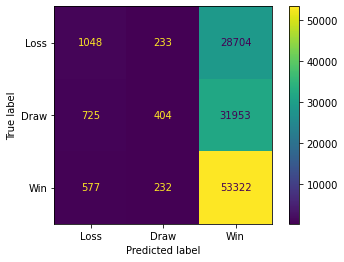

In [53]:
# Load pre-trained model to make predictions to check for overfitting
# clf = load('logisticRegression.joblib?dl=0')
y_pred = clf.predict(X_train)

# Create and visualise confusion matrix of results
cm = confusion_matrix(y_train, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot()

# Display the classification report of different metrics
pd.DataFrame(classification_report(y_train, y_pred, 
                            target_names=classes,
                            output_dict = True))

,Loss,Draw,Win,accuracy,macro avg,weighted avg
precision,0.469349,0.441441,0.465331,0.465222,0.458707,0.459558
recall,0.032719,0.011751,0.986342,0.465222,0.343604,0.465222
f1-score,0.061174,0.022892,0.632340,0.465222,0.238802,0.312897
support,7488.000000,8340.000000,13472.000000,0.465222,29300.000000,29300.000000


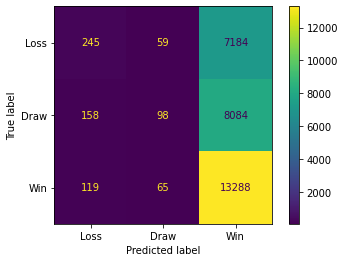

In [54]:
# Load pre-trained model to make predictions on testing set
# clf = load('logisticRegression.joblib?dl=0')
y_pred = clf.predict(X_test)

# Create and visualise confusion matrix of results
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot()

# Display the classification report of different metrics
pd.DataFrame(classification_report(y_test, y_pred, 
                            target_names=classes,
                            output_dict = True))

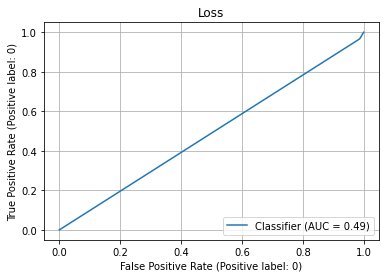

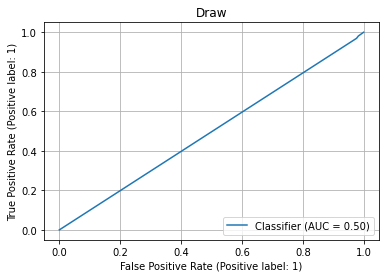

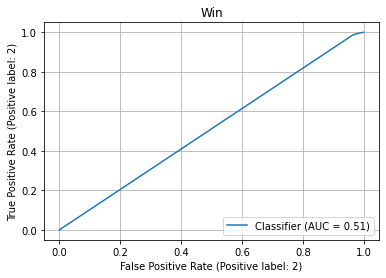

In [55]:
# Plot ROC curve for each of the 3 classes
for i in range(len(np.unique(y_test))):
  RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=i)
  plt.title(f'{classes[i]}')
  plt.grid()

## Support Vector Machine Classifier

In [ ]:
# Perform nested cross-validation for Support Vector Machine model
for train_ix, test_ix in cv.split(X_train):
  X_train_cv, X_test_cv = X_train[train_ix], X_train[test_ix]
  y_train_cv, y_test_cv = y_train[train_ix], y_train[test_ix]

  pca = PCA()
  svm = SVC()

  pipe = Pipeline(steps=[("pca", pca), ("svm", svm)])
  params = {"pca__n_components": [20, 50, 200, 500], 
            'svm__C':[0.01,0.1, 10,100,10e3], 
            'svm__gamma':[0.1,0.01],
            }

  clf = GridSearchCV(pipe, params, cv = 3, n_jobs=-1)

  result = clf.fit(X_train_cv, y_train_cv)
  best_model = clf.best_estimator_
  y_pred_cv = best_model.predict(X_test_cv)
  acc = accuracy_score(y_test_cv, y_pred_cv)

  print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, 
                                         result.best_params_))


>acc=0.455, est=0.468, cfg={'pca__n_components': 20, 'svm__C': 0.01, 'svm__gamma': 0.1}
>acc=0.471, est=0.464, cfg={'pca__n_components': 20, 'svm__C': 0.01, 'svm__gamma': 0.1}
>acc=0.486, est=0.461, cfg={'pca__n_components': 20, 'svm__C': 0.01, 'svm__gamma': 0.1}
>acc=0.465, est=0.466, cfg={'pca__n_components': 20, 'svm__C': 0.01, 'svm__gamma': 0.1}
>acc=0.451, est=0.469, cfg={'pca__n_components': 20, 'svm__C': 0.01, 'svm__gamma': 0.1}


In [ ]:
# Perform actual training on the model with the parameters which give the best
# prediction results
pca = PCA(n_components=20)
svm = SVC(C=0.01, 
          gamma=0.1)

clf = Pipeline(steps=[("pca", pca), ("svm", svm)])

# clf = load('supportVectorClassifier.joblib?dl=0')
clf.fit(X_train, y_train)
dump(clf, 'supportVectorClassifier.joblib')
files.download('supportVectorClassifier.joblib')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
# Load pre-trained model to make predictions to check for overfitting
# clf = load('supportVectorClassifier.joblib?dl=0')
y_pred = clf.predict(X_train)

# Create and visualise confusion matrix of results
cm = confusion_matrix(y_train, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot()

# Display the classification report of different metrics
pd.DataFrame(classification_report(y_train, y_pred, 
                            target_names=classes,
                            output_dict = True))

In [ ]:
# Make predictions on testing set
# clf = load('supportVectorClassifier.joblib?dl=0')
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=classes)
disp.plot()


# print(f1_score(y_test, y_pred, average='macro'), accuracy_score(y_test, y_pred))

pd.DataFrame(classification_report(y_test, y_pred, 
                            target_names=classes,
                            output_dict = True))

In [ ]:
# Plot ROC curve for each of the 3 classes
for i in range(len(np.unique(y_test))):
  RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=i)
  plt.title(f'{classes[i]}')
  plt.grid()

## K-Nearest Neighbors Classifier

In [ ]:
# Perform nested cross-validation for K-Nearest Neighbors model
for train_ix, test_ix in cv.split(X_train):
  X_train_cv, X_test_cv = X_train[train_ix], X_train[test_ix]
  y_train_cv, y_test_cv = y_train[train_ix], y_train[test_ix]

  pca = PCA()
  knn = KNeighborsClassifier(n_jobs=-1)

  pipe = Pipeline(steps=[("pca", pca), ("knn", knn)])
  params = {"pca__n_components": [20, 50, 200, 500],
            'knn__algorithm':['ball_tree', 'kd_tree', 'brute'], 
            'knn__leaf_size': [20, 30, 40]}

  clf = GridSearchCV(pipe, params, cv = 3, n_jobs=-1)

  result = clf.fit(X_train_cv, y_train_cv)
  best_model = clf.best_estimator_
  y_pred_cv = best_model.predict(X_test_cv)
  acc = accuracy_score(y_test_cv, y_pred_cv)

  print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, 
                                         result.best_params_))

{0.3640268456375839: {'knn__algorithm': 'ball_tree', 'knn__leaf_size': 20, 'pca__n_components': 50}, 0.3868456375838926: {'knn__algorithm': 'brute', 'knn__leaf_size': 40, 'pca__n_components': 140}, 0.3770139634801289: {'knn__algorithm': 'kd_tree', 'knn__leaf_size': 40, 'pca__n_components': 140}}


In [ ]:
# Perform actual training on the model with the parameters which give the best
# prediction results
pca = PCA(n_components=140)
knn = KNeighborsClassifier(algorithm= 'kd_tree', 
                           leaf_size = 40, 
                           n_jobs=-1)

clf = Pipeline(steps=[("pca", pca), ("knn", knn)])

# clf = load('kNearestNeigborsClassifier.joblib?dl=0')
clf.fit(X_train, y_train)
dump(clf, 'kNearestNeigborsClassifier.joblib')
files.download('kNearestNeigborsClassifier.joblib')

In [ ]:
# Load pre-trained model to make predictions to check for overfitting
# clf = load('kNearestNeigborsClassifier.joblib?dl=0')
y_pred = clf.predict(X_train)

# Create and visualise confusion matrix of results
cm = confusion_matrix(y_train, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot()

# Display the classification report of different metrics
pd.DataFrame(classification_report(y_train, y_pred, 
                            target_names=classes,
                            output_dict = True))

In [ ]:
# Make predictions on testing set
# clf = load('kNearestNeigborsClassifier.joblib?dl=0')
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=classes)
disp.plot()

pd.DataFrame(classification_report(y_test, y_pred, 
                            target_names=classes,
                            output_dict = True))

In [ ]:
# Plot ROC curve for each of the 3 classes
for i in range(len(np.unique(y_test))):
  RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=i)
  plt.title(f'{classes[i]}')
  plt.grid()

## Random Forest Classifier

In [ ]:
# Perform nested cross-validation for Random Forest model
for train_ix, test_ix in cv.split(X_train):
  X_train_cv, X_test_cv = X_train[train_ix], X_train[test_ix]
  y_train_cv, y_test_cv = y_train[train_ix], y_train[test_ix]

  pca = PCA()
  randomForest = RandomForestClassifier(random_state=0, n_jobs=-1)

  pipe = Pipeline(steps=[("pca", pca), ("randomForest", randomForest)])
  params = {"pca__n_components": [20, 50, 200, 500],
            'randomForest__n_estimators':[80, 100, 120]}

  clf = GridSearchCV(pipe, params, cv = 3, n_jobs=-1)

  result = clf.fit(X_train_cv, y_train_cv)
  best_model = clf.best_estimator_
  y_pred_cv = best_model.predict(X_test_cv)
  acc = accuracy_score(y_test_cv, y_pred_cv)
  
  print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, 
                                         result.best_params_))


{0.47838926174496643: {'pca__n_components': 20, 'randomForest__n_estimators': 100}, 0.4754362416107383: {'pca__n_components': 20, 'randomForest__n_estimators': 120}, 0.4712674543501611: {'pca__n_components': 20, 'randomForest__n_estimators': 120}}


In [ ]:
# Perform actual training on the model with the parameters which give the best
# prediction results
pca = PCA(n_components=20)
randomForest = RandomForestClassifier(n_estimators=120, 
                                      random_state=0, 
                                      n_jobs=-1)

clf = Pipeline(steps=[("pca", pca), ("randomForest", randomForest)])

# clf = load('randomForestClassifier.joblib?dl=0') 
clf.fit(X_train, y_train)
dump(clf, 'randomForestClassifier.joblib')
files.download('randomForestClassifier.joblib')

In [ ]:
# Load pre-trained model to make predictions to check for overfitting
# clf = load('randomForestClassifier.joblib?dl=0')
y_pred = clf.predict(X_train)

# Create and visualise confusion matrix of results
cm = confusion_matrix(y_train, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot()

# Display the classification report of different metrics
pd.DataFrame(classification_report(y_train, y_pred, 
                            target_names=classes,
                            output_dict = True))

In [ ]:
# Perform predictions on testing set
# clf = load('randomForestClassifier.joblib?dl=0')
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=classes)
disp.plot()


pd.DataFrame(classification_report(y_test, y_pred, 
                            target_names=classes,
                            output_dict = True))

In [ ]:
# Plot ROC curve for each of the 3 classes
for i in range(len(np.unique(y_test))):
  RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=i)
  plt.title(f'{classes[i]}')
  plt.grid()

## AdaBoost Classifier

In [ ]:
# Perform nested cross-validation for AdaBoost model
for train_ix, test_ix in cv.split(X_train):
  X_train_cv, X_test_cv = X_train[train_ix], X_train[test_ix]
  y_train_cv, y_test_cv = y_train[train_ix], y_train[test_ix]

  pca = PCA()
  adaBoost = AdaBoostClassifier(random_state=0)

  pipe = Pipeline(steps=[("pca", pca), ("adaBoost", adaBoost)])
  params = {"pca__n_components": [20, 50, 200, 500],
            'adaBoost__n_estimators':[30, 50, 80],
            'adaBoost__learning_rate': [0.5, 1.0, 1.5]}

  clf = GridSearchCV(pipe, params, cv = 3, n_jobs=-1)

  result = clf.fit(X_train_cv, y_train_cv)
  best_model = clf.best_estimator_
  y_pred_cv = best_model.predict(X_test_cv)
  acc = accuracy_score(y_test_cv, y_pred_cv)
  # accs[acc] = result.best_params_
  print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, 
                                         result.best_params_))

>acc=0.501, est=0.496, cfg={'adaBoost__learning_rate': 0.5, 'adaBoost__n_estimators': 30, 'pca__n_components': 20}
>acc=0.491, est=0.499, cfg={'adaBoost__learning_rate': 0.5, 'adaBoost__n_estimators': 50, 'pca__n_components': 140}
>acc=0.500, est=0.498, cfg={'adaBoost__learning_rate': 0.5, 'adaBoost__n_estimators': 30, 'pca__n_components': 20}


In [ ]:
# Perform actual training on the model with the parameters which give the best
# prediction results
pca = PCA(n_components=20)
adaBoost = AdaBoostClassifier(n_estimators=50, 
                              learning_rate=0.5, 
                              random_state=0)

clf = Pipeline(steps=[("pca", pca), ("adaBoost", adaBoost)])

# clf = load('adaBoostClassifier.joblib?dl=0') 
clf.fit(X_train, y_train)
dump(clf, 'adaBoostClassifier.joblib')
files.download('adaBoostClassifier.joblib')


In [ ]:
# Load pre-trained model to make predictions to check for overfitting
# clf = load('adaBoostClassifier.joblib?dl=0')
y_pred = clf.predict(X_train)

# Create and visualise confusion matrix of results
cm = confusion_matrix(y_train, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot()

# Display the classification report of different metrics
pd.DataFrame(classification_report(y_train, y_pred, 
                            target_names=classes,
                            output_dict = True))

In [ ]:
# Perform predictions on testing set
# clf = load('adaBoostClassifier.joblib?dl=0')
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot()


pd.DataFrame(classification_report(y_test, y_pred, 
                            target_names=classes,
                            output_dict = True))

In [ ]:
# Plot ROC curve for each of the 3 classes
for i in range(len(np.unique(y_test))):
  RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=i)
  plt.title(f'{classes[i]}')
  plt.grid()

## Gradient Boosting Classifier

In [ ]:
# Perform nested cross-validation for Gradient Boosting model
for train_ix, test_ix in cv.split(X_train):
  X_train_cv, X_test_cv = X_train[train_ix], X_train[test_ix]
  y_train_cv, y_test_cv = y_train[train_ix], y_train[test_ix]

  pca = PCA()
  gradBoost = GradientBoostingClassifier(random_state=0)

  pipe = Pipeline(steps=[("pca", pca), ("gradBoost", gradBoost)])
  params = {"pca__n_components": [20, 50, 200, 500],
            'gradBoost__n_estimators':[30, 50, 80],
            'gradBoost__learning_rate': [0.5, 1.0, 1.5]}

  clf = GridSearchCV(pipe, params, cv = 3, n_jobs=-1)
  # clf =  RandomizedSearchCV(pipe, params, cv = 3, random_state=0, n_jobs=-1)
 

  result = clf.fit(X_train_cv, y_train_cv)
  best_model = clf.best_estimator_
  y_pred_cv = best_model.predict(X_test_cv)
  acc = accuracy_score(y_test_cv, y_pred_cv)

  print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, 
                                         result.best_params_))

>acc=0.447, est=0.439, cfg={'gradBoost__learning_rate': 0.5, 'gradBoost__n_estimators': 30, 'pca__n_components': 500}
>acc=0.453, est=0.451, cfg={'gradBoost__learning_rate': 0.5, 'gradBoost__n_estimators': 30, 'pca__n_components': 200}
>acc=0.448, est=0.437, cfg={'gradBoost__learning_rate': 0.5, 'gradBoost__n_estimators': 30, 'pca__n_components': 500}
>acc=0.452, est=0.458, cfg={'gradBoost__learning_rate': 0.5, 'gradBoost__n_estimators': 30, 'pca__n_components': 500}
>acc=0.425, est=0.450, cfg={'gradBoost__learning_rate': 0.5, 'gradBoost__n_estimators': 50, 'pca__n_components': 50}


In [ ]:
# Perform actual training on the model with the parameters which give the best
# prediction results
pca = PCA(n_components=500)
gradBoost = GradientBoostingClassifier(n_estimators=30, 
                                       learning_rate=0.5, 
                                       random_state=0)

clf = Pipeline(steps=[("pca", pca), ("gradBoost", gradBoost)])

# clf = load('gradientBoostingClassifier.joblib?dl=0')
clf.fit(X_train, y_train)
dump(clf, 'gradientBoostingClassifier.joblib')
files.download('gradientBoostingClassifier.joblib')


In [ ]:
# Load pre-trained model to make predictions to check for overfitting
# clf = load('gradientBoostingClassifier.joblib?dl=0')
y_pred = clf.predict(X_train)

# Create and visualise confusion matrix of results
cm = confusion_matrix(y_train, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot()

# Display the classification report of different metrics
pd.DataFrame(classification_report(y_train, y_pred, 
                            target_names=classes,
                            output_dict = True))

In [ ]:
# Perform predictions on testing set
# clf = load('gradientBoostingClassifier.joblib?dl=0')
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot()


pd.DataFrame(classification_report(y_test, y_pred, 
                            target_names=classes,
                            output_dict = True))

In [ ]:
# Plot ROC curve for each of the 3 classes
for i in range(len(np.unique(y_test))):
  RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=i)
  plt.title(f'{classes[i]}')
  plt.grid()

# Summary of Prediction Results

From the $6$ ML classifiers that were chosen and trained on the data from the ```Football_Data```, the ```RandomForestClassifier``` model performed the best on the testing dataset with an accuracy of $0.48$ and a F1 score (macro avg) of $0.42$. However, the model is clearly overfit as it can seen (accuracy and F1 score of ≈ $0.99$) when it is made to predict on the training set. On the other hand, the worst performant model was the ```SVC``` model with an accuracy of $0.46$ and a F1 score of $0.21$.

Although it can be seen that the accuracy for some models is higher than the ```RandomForestClassifier``` model, their F1 score is far lower. Accuracy would be a bad metric to compare the models because of the amount of **Win** category in the dataset compared to the **Loss** and **Draw** categories.

However, it cannot be said that the ```RandomForestClassifier``` model is working because the F1 score is less than $50 \%$, which is the arbitrary threshold that was set to consider any model to make good predictions.

In the future, to improve the prediction score of the models, more variables/features could be included in the dataset to bring more information. Some examples could be the number of injuries, the percentage of possesion, the weather on the match day or the number of shots on target. Moreover, the nested cross-validation phase can be performed with more parameters as there may be combinations of these parameters that perform better than the current ones.